In [1]:
import numpy as np
import sympy as sp
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quil import DefGate
from pyquil.paulis import exponentiate
from pyquil.paulis import PauliSum
from pyquil.paulis import PauliTerm
import numpy as np
from scipy import linalg
from numpy.linalg import matrix_power
from pyquil.parameters import Parameter, quil_sin, quil_cos
from pyquil.api import WavefunctionSimulator
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
import scipy.special as sps
from scipy.stats import gamma
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats  
from matplotlib import cm

In [181]:
cliffords={0:I,
           1:X,
           2:Y,
           3:Z,
           4:([RX],[-np.pi/2]),
           5:([RX],[np.pi/2]),
           6:([RY],[-np.pi/2]),
           7:([RY],[np.pi/2]),
           8:([RZ],[-np.pi/2]),
           9:([RZ],[np.pi/2]),
           10:([RX,Z],[-np.pi/2,0]),
           11:([RX,Z],[np.pi/2,0]),
           12:([X,RZ],[0,-np.pi/2]),
           13:([X,RZ],[0,(np.pi/2)]),
           14:([RX,RZ],[(np.pi/2),(np.pi/2)]),
           15:([RX,RZ],[(-np.pi/2),(np.pi/2)]),
           16:([RZ,RX],[(-np.pi/2),(np.pi/2)]),
           17:([RY,Z],[(np.pi/2),(0)]),
           18:([RY,RZ],[(-np.pi/2),(np.pi/2)]),
           19:([RY,RZ],[(np.pi/2),(-np.pi/2)]),
           20:H,
           21:([RX,RZ],[(np.pi/2),(-np.pi/2)]),
           22:([RY,RZ],[(np.pi/2),(np.pi/2)]),
           23:([RX,RZ],[(-np.pi/2),(-np.pi/2)]),            
}

In [182]:
def cliffords_to_program(gate,qubit):     
    prog=[]
    
    if (gate==1 or gate==2 or gate==3 or gate ==0 or gate == 20):
            
        prog.append(cliffords[gate](qubit))

    else :

        for i in range(len(cliffords[gate][0])):
            if (cliffords[gate][1][i]!=0):
                prog.append(cliffords[gate][0][i](cliffords[gate][1][i],qubit))
            else:
                prog.append(cliffords[gate][0][i](qubit))
    
    return prog

In [183]:
delta =Parameter('delta')

noise_z=np.array([[quil_cos((delta))-1j*quil_sin((delta)),0],
              [0,1j*quil_sin((delta))+quil_cos((delta))]])

noise_z_definition = DefGate('Noise_z', noise_z, [delta])
Noise_z = noise_z_definition.get_constructor()


# Theoretical

In [184]:
def generate_sequence_cliffords(length,full_p,indexes,deltas,N_Qubits):    

    full_p+=noise_z_definition
    
    program=[]
    inverse=Program()
    
    for indexx,deltaa in zip(indexes,deltas):
        for qubit in range(N_Qubits):
            
            index=indexx[qubit]
            delta=deltaa[qubit]
        
            noise=Noise_z(delta)(qubit)
            program.append(noise)
            program.append(cliffords_to_program(index,qubit))
            inverse+=cliffords_to_program(index,qubit)
        
    full_p+=program 
    full_p+=inverse.dagger()
    
    return full_p

In [185]:
def write_data(values,path):
    with open(path, 'a') as the_file:
        for value in values:
            the_file.write(str(value)+',')
        the_file.write('\n')
        

## Markovian scenario

### Parameters

In [131]:
def markovian_theoretical(sigma_error,J,N_Qubits,trials,N,path):
    final=[]    
    for i in tqdm_notebook(range(trials)):
        indexes=np.random.randint(0,24,(J,N_Qubits)) 
        results=[]
        for j in range (N):
            deltas=np.random.normal(0,sigma_error,(J,N_Qubits))
            correction=np.sum(deltas**2)
            p=generate_sequence_cliffords(J,Program(),indexes,deltas,N_Qubits)
            wf_sim = WavefunctionSimulator()
            wavefunction = wf_sim.wavefunction(p)
            results.append(abs(wavefunction[0]**2))
        final.append(np.mean(results))
    write_data(final,path)



In [132]:
sigma_error=0.015
Js=[100]
N=50
trials=200
N_Qubitss=[1]

timestr = time.strftime("%m%d-%H%M%S")
path1='results/FidTest/markovian-'+timestr+".txt"


with open(path1, 'w') as the_file:
    the_file.write('N='+str(N)+' J = '+str(Js)+' NQ = '+str(N_Qubitss)+' sigma = '+str(sigma_error)+'\n')


In [133]:
for N_Qubits in N_Qubitss:
    for J in Js: 
        markovian_theoretical(sigma_error,J,N_Qubits,trials,N,path1)

(0.9, 1)

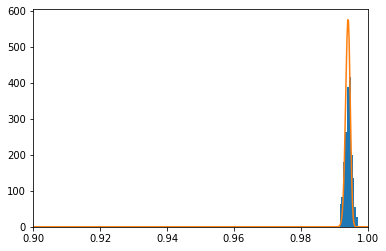

In [186]:
sigma_error=0.015
Js=(2/3)*np.array([20,40,60,80,100])
N=50
trials=2000
N_Qubitss=[1,2,3]

N_Qubit=1
J_index=1

Big_index=(N_Qubit-1)*5+J_index


#path1='results/FinalResults/markovian-0705-233112.txt'
results=np.genfromtxt(path1,skip_header=1,delimiter=',')[:-1]
plt.hist(results,bins=10,density=1)

sigma2=sigma_error**2
alpha=N_Qubit*3/2*N
beta=(2/3)*Js[J_index]*sigma2/N
x=np.linspace(0,0.2,1000)
center=1-x+(2/3)*Js[J_index]*sigma2**2



plt.plot(center,gamma.pdf(x,alpha,0,beta))
plt.xlim(0.9,1)

### DC

In [377]:
def DC_theoretical(sigma_error,J,N_Qubits,trials,N,path):
    final=[]
    for i in tqdm_notebook(range(trials)):
        indexes=np.random.randint(0,24,(J,N_Qubits)) 
        results=[]
        for j in range(N):
            deltas=[[np.random.normal(0,sigma_error)]*N_Qubits]*J
            p=generate_sequence_cliffords(J,Program(),indexes,deltas,N_Qubits)
            wf_sim = WavefunctionSimulator()
            wavefunction = wf_sim.wavefunction(p)
            results.append(abs(wavefunction[0])**2)
        correction=np.random.gamma(1/2,(2/3)*J)*sigma_error**2
        correction2=np.random.gamma(1/2,(2/3)*J)*sigma_error**2
        #correction3=np.random.gamma(1/2,(2/3)*J)*sigma_error**2
        final.append(np.mean(results)-correction-correction2)
    write_data(final,path)

In [378]:
sigma_error=0.015
Js=[20,40,60,80,100]
trials=2000
N=50
N_Qubitss=[2]

timestr = time.strftime("%m%d-%H%M%S")
path2='results/FidTest/DC-'+timestr+".txt"

with open(path2, 'w') as the_file:
    the_file.write('N='+str(N)+' J = '+str(Js)+' NQ = '+str(N_Qubitss)+' sigma = '+str(sigma_error)+'\n')

In [379]:
for N_Qubits in N_Qubitss:
    for J in Js:
        DC_theoretical(sigma_error,J,N_Qubits,trials,N,path2)

0.0105131338717472


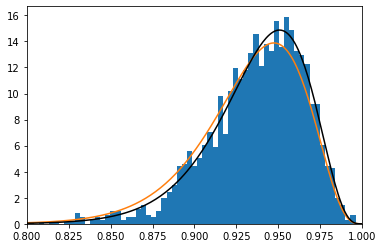

In [369]:
sigma_error=0.015
Js=np.array([20,40,60,80,100])
N=50
N_Qubitss=[1,2,3]

#path2='results/FidTest/DC-0718-135446.txt'

results=np.genfromtxt(path2,skip_header=1,delimiter=',')[:-1]

plt.hist(results,bins=70,density=1)

sigma2=sigma_error**2
alpha=3*3/2
beta=(2/3)*Js[4]*sigma2

x=np.linspace(0,1,1000)
y = (1-x)**(alpha-1)*(np.exp(-((1-x)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
plt.plot(x,y)


ag,bg,cg = stats.gamma.fit(1-results,floc=0)  
pdf_gamma = stats.gamma.pdf(x, ag, bg,cg)  
plt.plot(1-x, pdf_gamma, label="Gamma",c='k')
plt.xlim(0.8,1)

print(stats.entropy(y+0.0000001,stats.gamma.pdf(1-x, ag,0,cg)+0.0000001))

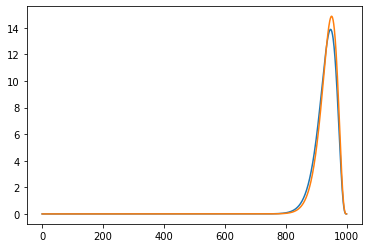

In [370]:
plt.plot(y)
plt.plot(stats.gamma.pdf(1-x, ag,0,cg))

array([0.97398694, 0.99201179, 0.9899586 , 0.9973897 , 0.96777174,
       0.98504085, 0.9661251 , 0.99034024, 0.97292765, 0.98636037,
       0.96129158, 0.97803157, 0.98956511, 0.9588781 , 0.98919036,
       0.9792453 , 0.98135415, 0.94036482, 0.99059397, 0.98823632,
       0.95645853, 0.97113238, 0.99654589, 0.98607692, 0.99200036,
       0.98976476, 0.99147073, 0.99499651, 0.99084425, 0.98376928,
       0.99162129, 0.98758068, 0.97211393, 0.98890005, 0.98773393,
       0.98651251, 0.97668695, 0.98287789, 0.99464307, 0.990779  ,
       0.97880033, 0.98450065, 0.91915172, 0.99483009, 0.99702307,
       0.99725822, 0.92318685, 0.97623954, 0.99020641, 0.9628953 ,
       0.97570666, 0.99106333, 0.97880526, 0.97732522, 0.99209769,
       0.98507955, 0.98562701, 0.98060939, 0.99194698, 0.9695146 ,
       0.96547335, 0.98666845, 0.97984589, 0.97908256, 0.94906095,
       0.97912413, 0.96451397, 0.98216581, 0.99692348, 0.9291342 ,
       0.97365338, 0.94590792, 0.96789619, 0.98221754, 0.96334

# Ion Trap

In [390]:
theta = Parameter('theta')
delta =Parameter('delta')
u_x=np.array([[quil_cos((theta+delta)/2),1j*quil_sin((theta+delta)/2)],
              [1j*quil_sin((theta+delta)/2),quil_cos((theta+delta)/2)]])

u_z=np.array([[quil_cos((theta+delta)/2)+1j*quil_sin((theta+delta)/2),0],
              [0,-1j*quil_sin((theta+delta)/2)+quil_cos((theta+delta)/2)]])

u_y=np.array([[quil_cos((theta+delta)/2),quil_sin((theta+delta)/2)],
              [-quil_sin((theta+delta)/2),quil_cos((theta+delta)/2)]])

U_x_definition = DefGate('U_x', u_x, [theta,delta])
U_x = U_x_definition.get_constructor()

U_z_definition = DefGate('U_z', u_z, [theta,delta])
U_z = U_z_definition.get_constructor()

U_y_definition = DefGate('U_y', u_y, [theta,delta])
U_y = U_y_definition.get_constructor()

In [391]:
#Defining again, but with sign change to match the other operators
cliffords_2={0:I,
           1:X,
           2:Y,
           3:Z,
           4:([RX],[-np.pi/2]),
           5:([RX],[np.pi/2]),
           6:([RY],[-np.pi/2]),
           7:([RY],[np.pi/2]),
           8:([RZ],[-np.pi/2]),
           9:([RZ],[np.pi/2]),
           10:([RX,Z],[-np.pi/2,0]),
           11:([RX,Z],[np.pi/2,0]),
           12:([X,RZ],[0,-np.pi/2]),
           13:([X,RZ],[0,(np.pi/2)]),
           14:([RX,RZ],[(-np.pi/2),(-np.pi/2)]),
           15:([RX,RZ],[(np.pi/2),(-np.pi/2)]),
           16:([RZ,RX],[(np.pi/2),(-np.pi/2)]),
           17:([RY,Z],[(np.pi/2),(0)]),
           18:([RY,RZ],[(np.pi/2),(-np.pi/2)]),
           19:([RY,RZ],[(-np.pi/2),(np.pi/2)]),
           20:H,
           21:([RX,RZ],[(-np.pi/2),(np.pi/2)]),
           22:([RY,RZ],[(-np.pi/2),(-np.pi/2)]),
           23:([RX,RZ],[(np.pi/2),(np.pi/2)]),            
}

In [392]:
generators={   
    #X
    1:([U_z,U_x,U_z,U_x],[-np.pi,-np.pi/2,np.pi,np.pi/2]),
    #Y
    2:([U_z,U_y,U_z,U_y],[-np.pi,-np.pi/2,np.pi,np.pi/2]),
    #Z
    3:([U_z],[np.pi]),
    #Rx+
    4:([U_z,U_x,U_z,U_x],[-np.pi,-np.pi/4,np.pi,np.pi/4]),
    #Rx-
    5:([U_z,U_x,U_z,U_x],[-np.pi,np.pi/4,np.pi,-np.pi/4]),
    #Ry+
    6:([U_z,U_y,U_z,U_y],[-np.pi,-np.pi/4,np.pi,np.pi/4]),
    #Ry-
    7:([U_z,U_y,U_z,U_y],[-np.pi,np.pi/4,np.pi,-np.pi/4]),
    #Rz+
    8:([U_z],[np.pi/2]),
    #Rz-
    9:([U_z],[-np.pi/2])   
}

compilation={
    0:(generators[3][0]+generators[3][0],generators[3][1]+generators[3][1]),
    1:generators[1],
    2:generators[2],
    3:generators[3],
    4:generators[4],
    5:generators[5],
    6:generators[6],
    7:generators[7],
    8:generators[8],
    9:generators[9],
    #ZRx+
    10:(generators[3][0]+generators[4][0],generators[3][1]+generators[4][1]),
    #ZRx-
    11:(generators[3][0]+generators[5][0],generators[3][1]+generators[5][1]),
    #Rz+X
    12:(generators[8][0]+generators[1][0],generators[8][1]+generators[1][1]),
    #Rz-X
    13:(generators[9][0]+generators[1][0],generators[9][1]+generators[1][1]),
    #Rz+X
    14:(generators[8][0]+generators[4][0],generators[8][1]+generators[4][1]),
    15:(generators[8][0]+generators[5][0],generators[8][1]+generators[5][1]),
    
    16:(generators[4][0]+generators[9][0],generators[4][1]+generators[9][1]),
    
    17:(generators[3][0]+generators[7][0],generators[3][1]+generators[7][1]),
    
    18:(generators[8][0]+generators[7][0],generators[8][1]+generators[7][1]),
    
    19:(generators[9][0]+generators[6][0],generators[9][1]+generators[6][1]),
    
    20:(generators[3][0]+generators[6][0],generators[3][1]+generators[6][1]),
    
    21:(generators[9][0]+generators[4][0],generators[9][1]+generators[4][1]),
    
    22:(generators[8][0]+generators[6][0],generators[8][1]+generators[6][1]),
    
    23:(generators[9][0]+generators[5][0],generators[9][1]+generators[5][1])
}

In [393]:
def inverse(list_c):
    
    prog=[]
    
    for element in list_c:
        
        gate=element[0]
        qubit=element[1]
        
        if (gate==1 or gate==2 or gate==3 or gate ==0 or gate == 20):
            
            prog.append(cliffords_2[gate](qubit))
        
        else :
            
            for i in range(len(cliffords_2[gate][0])):
                if (cliffords_2[gate][1][i]!=0):
                    prog.append(cliffords_2[gate][0][i](cliffords_2[gate][1][i],qubit))
                else:
                    prog.append(cliffords_2[gate][0][i](qubit))
    return prog

In [394]:
def compilation_to_program(N,clifford,qubit,noise=0): 
    prog=[]
    
    gates=compilation[clifford]

    for i in range(len(gates[0])):

        gate=gates[0][i]
        angle=gates[1][i]            

        if(gate==U_z):

            prog.append(gate(angle,noise)(qubit))

        else:
            for j in range(N):              
                prog.append(gate(angle,noise)(j))
         
    return prog[::-1]

In [395]:
def generate_sequence(length,full_p,N,indexes,deltas,N_Qubits):

    program=[]
    inverseP=Program()
    
    aux_inverse=[]
    
    for indexx,deltaa in zip(indexes,deltas):
        for qubit in range(N_Qubits):
            
            index=indexx[qubit]
            delta=deltaa[qubit]
            gate=compilation_to_program(N,index,qubit,noise=delta)
            aux_inverse.append((index,qubit))
            program.append(gate)

                   
    inverseP+=inverse(aux_inverse)
    full_p+=program 
    full_p+=inverseP.dagger()
    
    
    return full_p

## Markov

In [396]:
def markov_real(sigma_error,J,N_Qubits,trials,N,path):
    final=[]
    for i in tqdm_notebook(range(trials)):
        indexes=np.random.randint(0,24,(J,N_Qubits)) 
        results=[]
        for j in range (N):
            p = Program()
            p+=U_x_definition
            p+=U_y_definition
            p+=U_z_definition
            deltas=np.random.normal(0,sigma_error,(J,N_Qubits))
            correction=np.sum(deltas**2)
            p=generate_sequence(J,p,N_Qubits,indexes,deltas,N_Qubits)    
            wf_sim = WavefunctionSimulator()
            wavefunction = wf_sim.wavefunction(p)
            results.append(abs(wavefunction[0])**2-(1/3)*correction)
        final.append(np.mean(results))
    write_data(final,path)

In [49]:
sigma_error=0.015
Js=[20,40,60,80,100]
N_Qubitss=[1,2,3]
trials=1000
N=50
timestr = time.strftime("%m%d-%H%M%S")
path3='results/Harris/markovianIT''-'+timestr+".txt"

with open(path3, 'w') as the_file:
    the_file.write('Iont Trap N='+str(N)+' J = '+str(Js)+' NQ = '+str(N_Qubitss)+' sigma = '+str(sigma_error)+'\n')

In [50]:
for N_Qubits in N_Qubitss:
    for J in Js:
        markov_real(sigma_error,J,N_Qubits,trials,N,path3)

(0.9, 1)

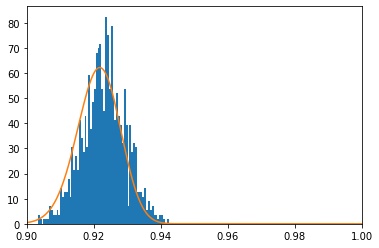

In [60]:
path3='results/harris/markovianIT-0628-225902.txt'

sigma_error=0.015
Js=[20,40,60,80,100]
N_Qubitss=[1,2,3]
trials=1000
N=50

N_Qubit=2
J_index=4

Big_index=(N_Qubit-1)*5+J_index

results=np.genfromtxt(path3,skip_header=1,delimiter=',')[:,:-1]
plt.hist(results[Big_index],bins=70,density=1)

sigma2=sigma_error**2
alpha=N_Qubit*3/2*N
beta=1.75*(2/3)*Js[J_index]*sigma2/N
x=np.linspace(0,0.2,1000)
center=1-x+(2/2)*Js[J_index]*sigma2**2

#y = (1-x+(2/3)*Js[1]*sigma2**2)**(alpha-1)*(np.exp(-((1-x+(2/3)*Js[1]*sigma2**2)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
plt.plot(center,gamma.pdf(x,alpha,0,beta))
#plt.plot(x,y)
plt.xlim(0.9,1)






In [397]:
def DC_real(sigma_error,J,N_Qubits,trials,N,path):
    final=[]
    for i in tqdm_notebook(range(trials)):
        indexes=np.random.randint(0,24,(J,N_Qubits)) 
        results=[]
        for j in range (N):
            p = Program()
            p+=U_x_definition
            p+=U_y_definition
            p+=U_z_definition
            deltas=[[np.random.normal(0,sigma_error)]*N_Qubits]*J
            p=generate_sequence(J,p,N_Qubits,indexes,deltas,N_Qubits)
            wf_sim = WavefunctionSimulator()
            wavefunction = wf_sim.wavefunction(p)
            results.append(abs(wavefunction[0])**2)
        correction=np.random.gamma(1/2,N_Qubits*(2/3)*J)*sigma_error**2
        correction2=np.random.gamma(1/2,N_Qubits*(2/3)*J)*sigma_error**2
        correction3=np.random.gamma(1/2,N_Qubits*(2/3)*J)*sigma_error**2
        final.append(np.mean(results)-correction-correction2-correction3)
    write_data(final,path)
        

In [398]:
sigma_error=0.015
Js=[20,40,60,80,100]
N_Qubitss=[3]
trials=1000
N=50

timestr = time.strftime("%m%d-%H%M%S")
path4='results/FidTest/DCIT''-'+timestr+".txt"

with open(path4, 'w') as the_file:
    the_file.write('Iont Trap N='+str(N)+' J = '+str(Js)+' NQ = '+str(N_Qubitss)+' sigma = '+str(sigma_error)+'\n')

In [399]:
for N_Qubits in N_Qubitss:
    for J in Js:
        DC_real(sigma_error,J,N_Qubits,trials,N,path4)

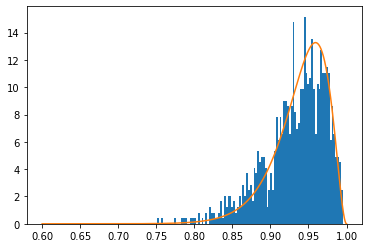

In [169]:
## sigma_error=0.015
Js=[20,40,60,80,100]
N_Qubitss=[1,2,3]
trials=1000
N=50

path4='results/harris2/DCIT-0704-154333.txt'

results=np.genfromtxt(path4,skip_header=1,delimiter=',')[:,:-1]
plt.hist(results[8],bins=100,density=1)

sigma2=sigma_error**2
alpha=6/2
beta=(2/3)*1.7*Js[3]*sigma2

x=np.linspace(0.6,1,1000)
y = (1-x)**(alpha-1)*(np.exp(-((1-x)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
plt.plot(x,y)
#plt.xlim(0.9,1)

# Analysis

## Markovian theory

In [2]:
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
trials=2000
N_Qubitss=[1,2,3]


path1='results/FinalResults/markovian-0705-233112.txt'
results1=np.genfromtxt(path1,skip_header=1,delimiter=',')[:,:-1]
means1=np.mean(results1,axis=1)

0.0761
0.0196
0.0179
0.0235
0.0294
0.1085
0.0441
0.0342
0.0425
0.0405
0.1563
0.0597
0.0642
0.0835
0.1113


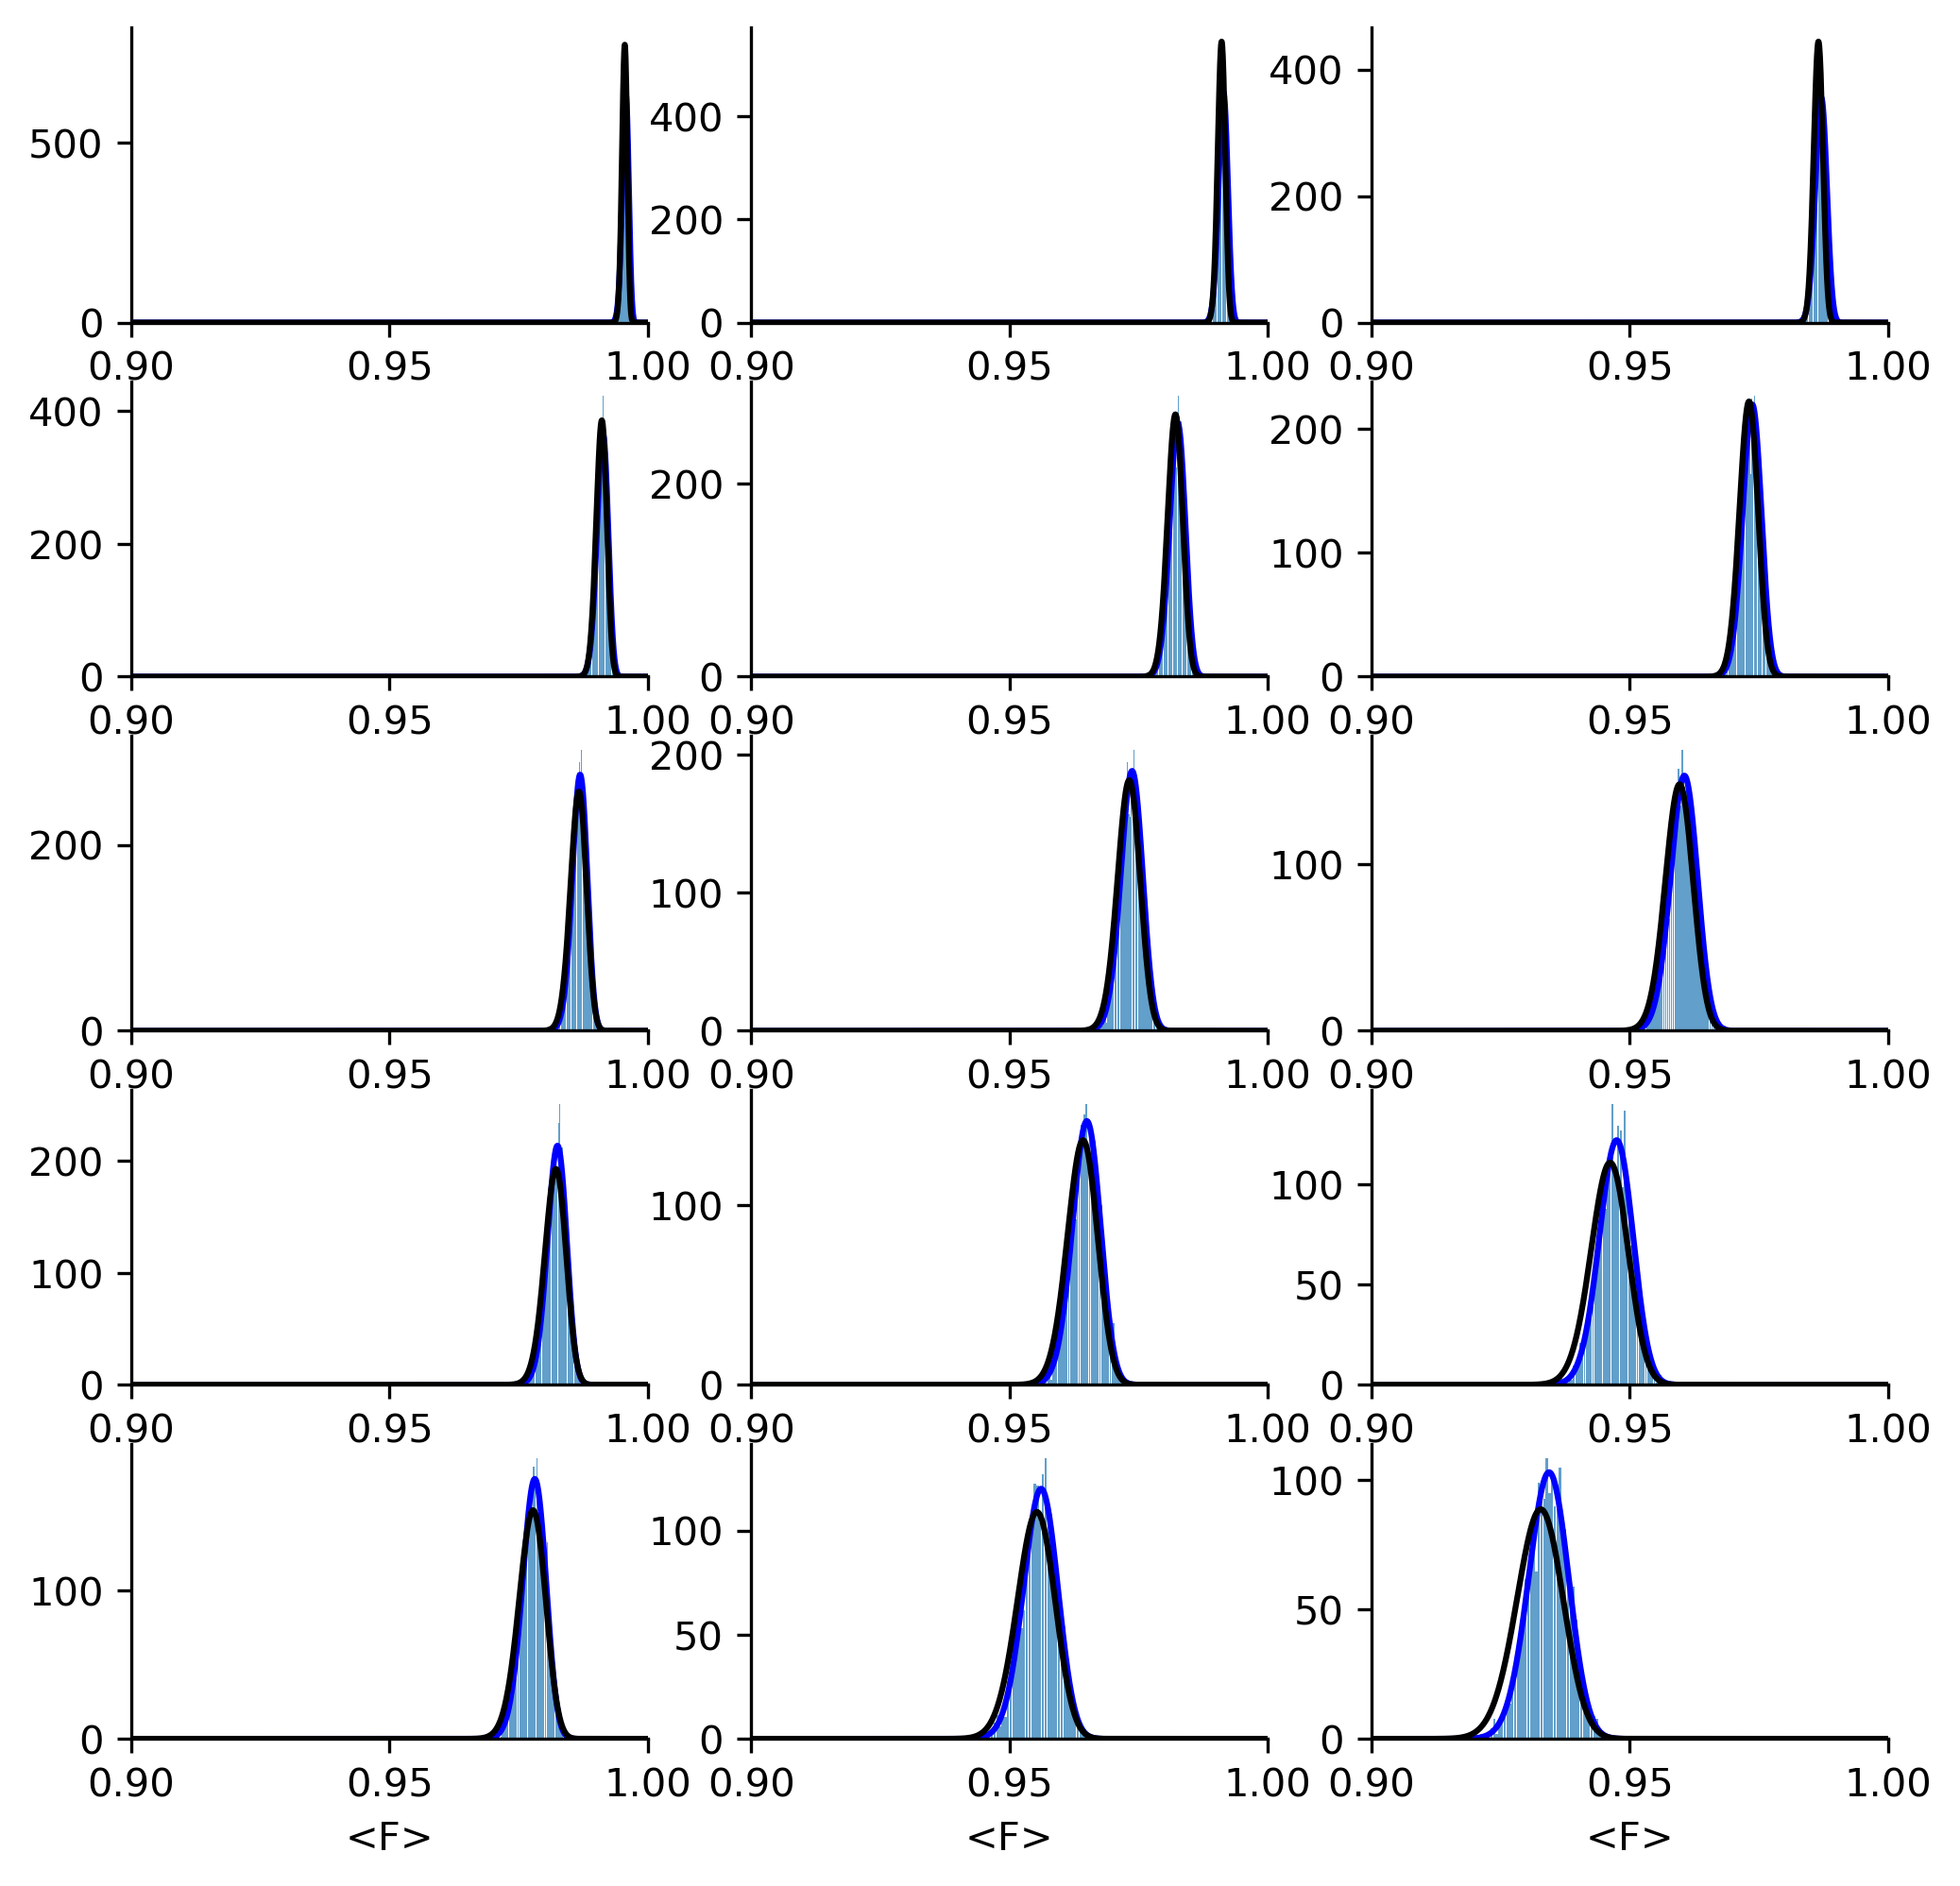

In [4]:
plt.figure(figsize=(8,8),dpi=300)
N_Qubit=1
J_index=4

for N_Qubit in range (1,4):
    for J_index in range(5):
        

        Big_index=(N_Qubit-1)*5+J_index
        ax1 = plt.subplot(5,3,(Big_index%5*3)+Big_index//5+1)  
        ax1.spines["top"].set_visible(False)  
        ax1.spines["right"].set_visible(False)

        plt.hist(results1[Big_index],bins=50,density=1,alpha=0.7,rwidth=0.85)

        sigma2=sigma_error**2
        alpha=N_Qubit*3/2*N
        beta=(2/3)*Js[J_index]*sigma2/N
        x=np.linspace(0,0.2,10000)
        center=1-x+(2/3)*Js[J_index]*sigma2**2
        x2=np.linspace(0.8,1,10000)

        ag,bg,cg = stats.gamma.fit(1-results1[Big_index],floc=0)  
        pdf_gamma = stats.gamma.pdf(1-x2, ag,0,cg)  
        plt.plot(x2, pdf_gamma, label="Gamma",c='b')

        plt.plot(center,gamma.pdf(x,alpha,0,beta),c='k')
        plt.xlim(0.9,1)
        plt.xlabel("<F>")
        plt.xticks([0.9,0.95,1])
        
        print(round(stats.entropy(gamma.pdf(x,alpha,0,beta)[::-1]+0.0000001,stats.gamma.pdf(1-x2, ag,0,cg)+0.0000001),4))
plt.savefig('distriMarkteo.pdf',bbox_inches = 'tight',pad_inches = 0)    

In [319]:
stats.entropy(gamma.pdf(x,alpha,alpha*beta,beta)+0.001,stats.gamma.pdf(1-x2, ag,0,cg)+0.001)

0.05868030960637558

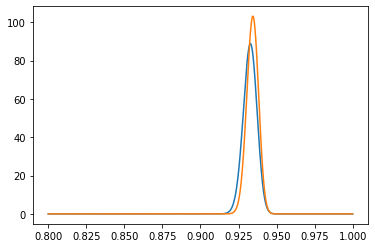

In [328]:
plt.plot(x2,gamma.pdf(x,alpha,0,beta)[::-1]+0.001)
plt.plot(x2,gamma.pdf(1-x2, ag,0,cg)+0.001)

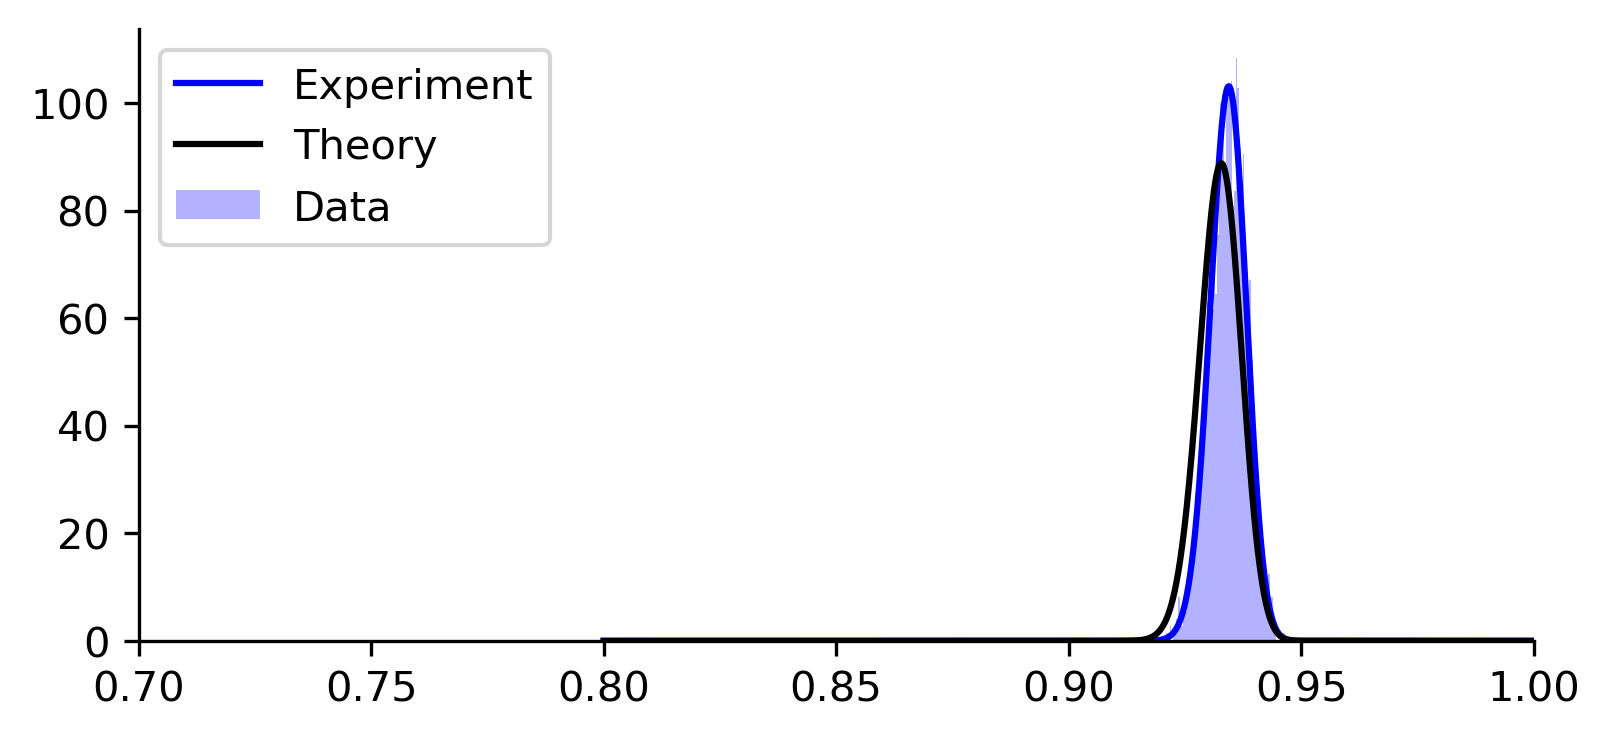

In [560]:

plt.figure(figsize=(6,2.7),dpi=300)

ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

N_Qubit=3
J_index=4

Big_index=(N_Qubit-1)*5+J_index

plt.hist(results1[Big_index],bins=70,density=1,alpha=0.3,color='blue',label='Data')

sigma2=sigma_error**2
alpha=N_Qubit*3/2*N
beta=(2/3)*Js[J_index]*sigma2/N
x=np.linspace(0,0.2,10000)
center=1-x+(2/3)*Js[J_index]*sigma2**2
x2=np.linspace(0.8,1,10000)

ag,bg,cg = stats.gamma.fit(1-results1[Big_index],floc=0)  
pdf_gamma = stats.gamma.pdf(1-x2, ag,0,cg)  
plt.plot(x2, pdf_gamma,c='b',label='Experiment')

plt.plot(center,gamma.pdf(x,alpha,0,beta),c='k',label='Theory')
plt.xlim(0.7,1)


plt.legend()

plt.savefig('Mark3qJ5.pdf',bbox_inches = 'tight',pad_inches = 0)

In [308]:
1-alpha*beta

0.946

## DC Theory

In [3]:
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
N_Qubitss=[1,2,3]

path2='results/FinalResults/DC-0730-131359.txt'

results2=np.genfromtxt(path2,skip_header=1,delimiter=',')[:,:-1]
means2=np.mean(results2,axis=1)

0.0035
0.0006
0.0001
0.0004
0.0017
0.0023
0.0029
0.002
0.0024
0.0048
0.0026
0.0017
0.0027
0.0105
0.0105


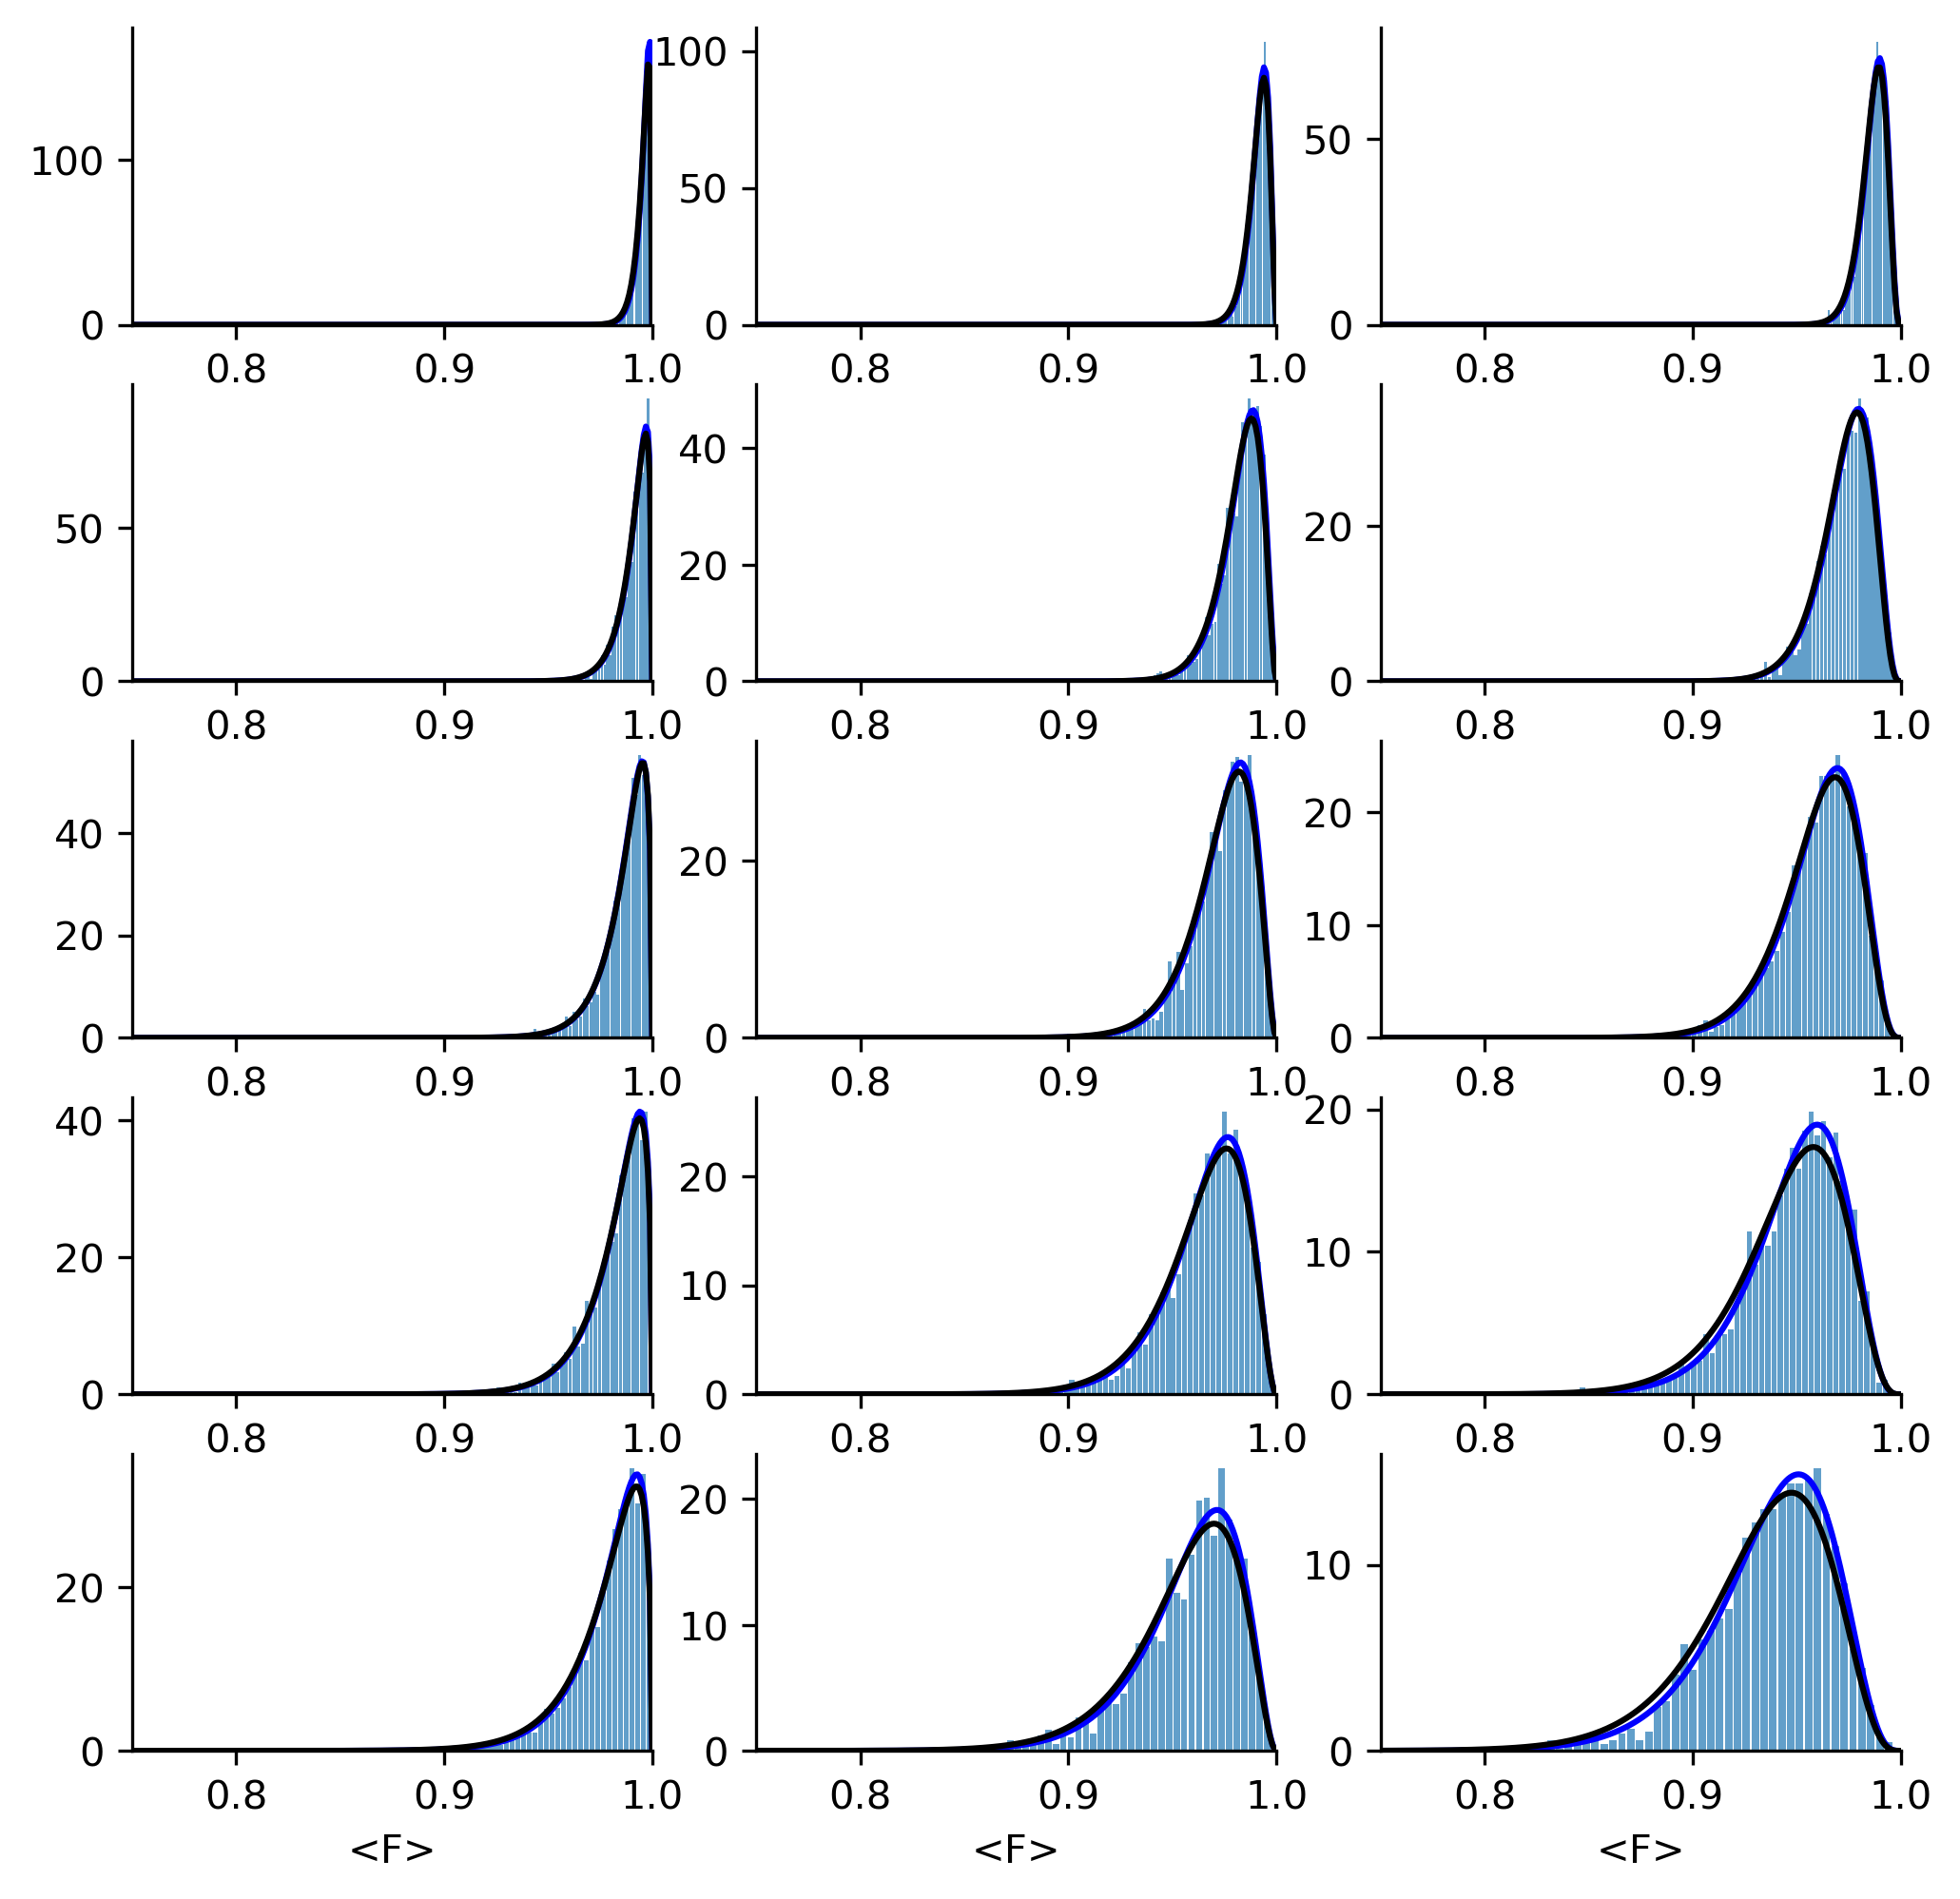

In [6]:
plt.figure(figsize=(8,8),dpi=300)
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
N_Qubitss=[1,2,3]


for N_Qubit in range (1,4):
    for J_index in range(5):
        Big_index=(N_Qubit-1)*5+J_index


        ax1 = plt.subplot(5,3,(Big_index%5*3)+Big_index//5+1)  
        ax1.spines["top"].set_visible(False)  
        ax1.spines["right"].set_visible(False)

        plt.hist(results2[Big_index],bins=50,density=1,alpha=0.7,rwidth=0.85)

        sigma2=sigma_error**2
        alpha=N_Qubit*3/2
        beta=(2/3)*Js[J_index]*sigma2

        x=np.linspace(0,1,1000)
        y = (1-x)**(alpha-1)*(np.exp(-((1-x)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
        ag,bg,cg = stats.gamma.fit(1-results2[Big_index],floc=0)  
        pdf_gamma = stats.gamma.pdf(x, ag, bg,cg)  
        plt.plot(1-x, pdf_gamma, label="Gamma",c='b')
        plt.plot(x,y,c='k')
        plt.xlim(0.75,1)
        
        ax1.set_xlabel("<F>")
            

        print(round(stats.entropy(gamma.pdf(x,alpha,0,beta)[::-1]+0.0000001,stats.gamma.pdf(1-x, ag,0,cg)+0.0000001),4))

plt.savefig('distriDCteo.pdf',bbox_inches = 'tight',pad_inches = 0)

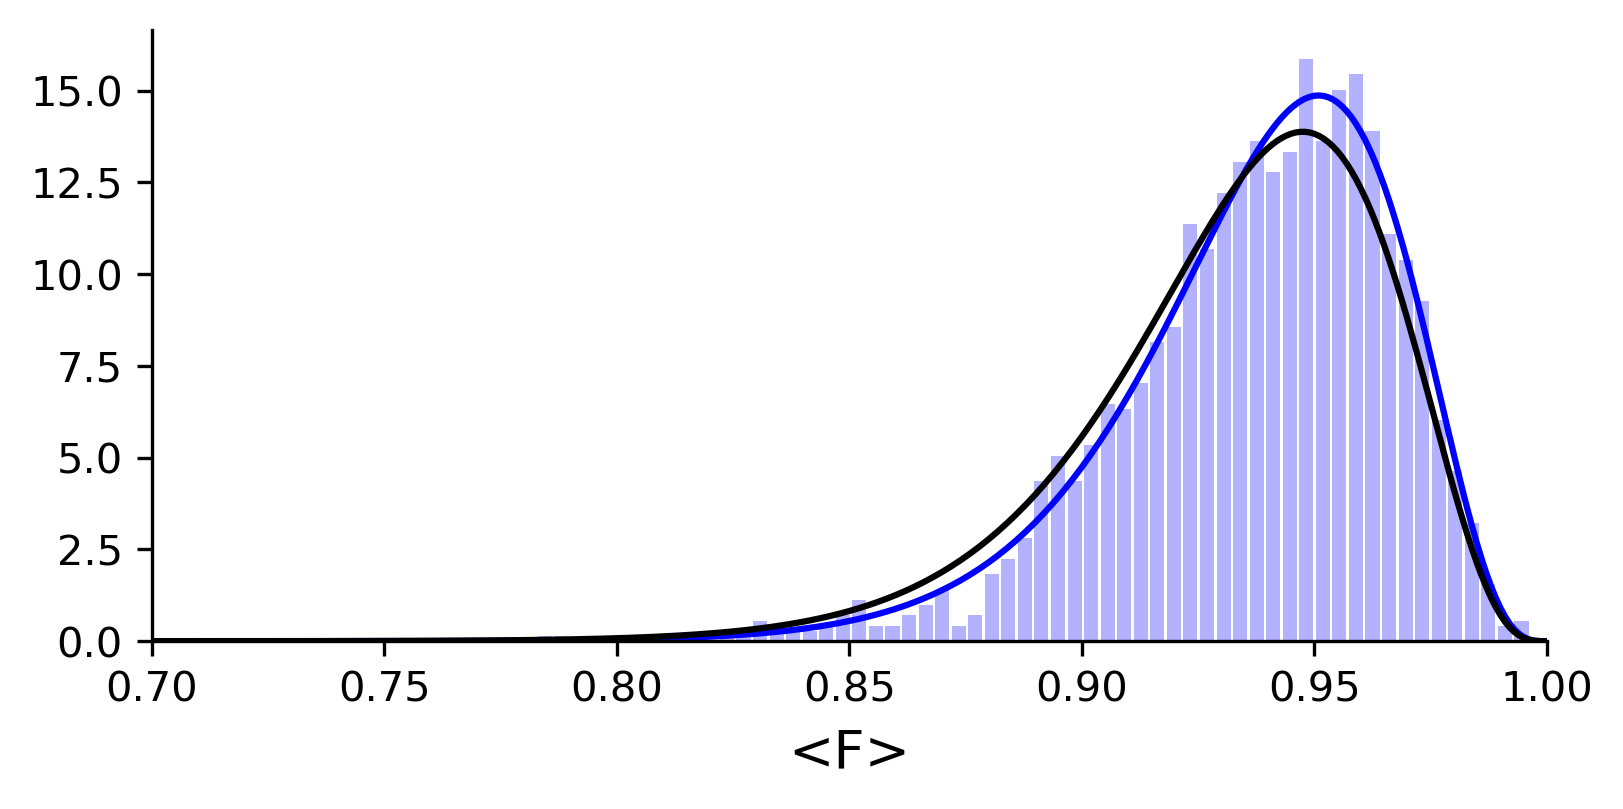

In [561]:
N_Qubit=3
J_index=4
Big_index=(N_Qubit-1)*5+J_index

plt.figure(figsize=(6,2.7),dpi=300)

ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

#plt.subplot(5,3,(Big_index%5*3)+Big_index//5+1)
plt.hist(results2[Big_index],bins=60,density=1,alpha=0.3,color='blue',label='Data',rwidth=0.85)

sigma2=sigma_error**2
alpha=N_Qubit*3/2
beta=(2/3)*Js[J_index]*sigma2

x=np.linspace(0,1,1000)
y = (1-x)**(alpha-1)*(np.exp(-((1-x)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
ag,bg,cg = stats.gamma.fit(1-results2[Big_index],floc=0)  
pdf_gamma = stats.gamma.pdf(x, ag, bg,cg)  
plt.plot(1-x, pdf_gamma,c='b',label='Experimental')
plt.plot(x,y,c='k',label='Theory')
plt.xlim(0.7,1)
plt.xlabel('<F>',size=13)


plt.savefig('DC3qJ5.pdf',bbox_inches = 'tight',pad_inches = 0)

## Markovian real

In [4]:
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
N_Qubitss=[1,2,3]


path3='results/FinalResults/markovianIT-0628-225902.txt'
results3=np.genfromtxt(path3,skip_header=1,delimiter=',')[:,:-1]
means3=np.mean(results3,axis=1)

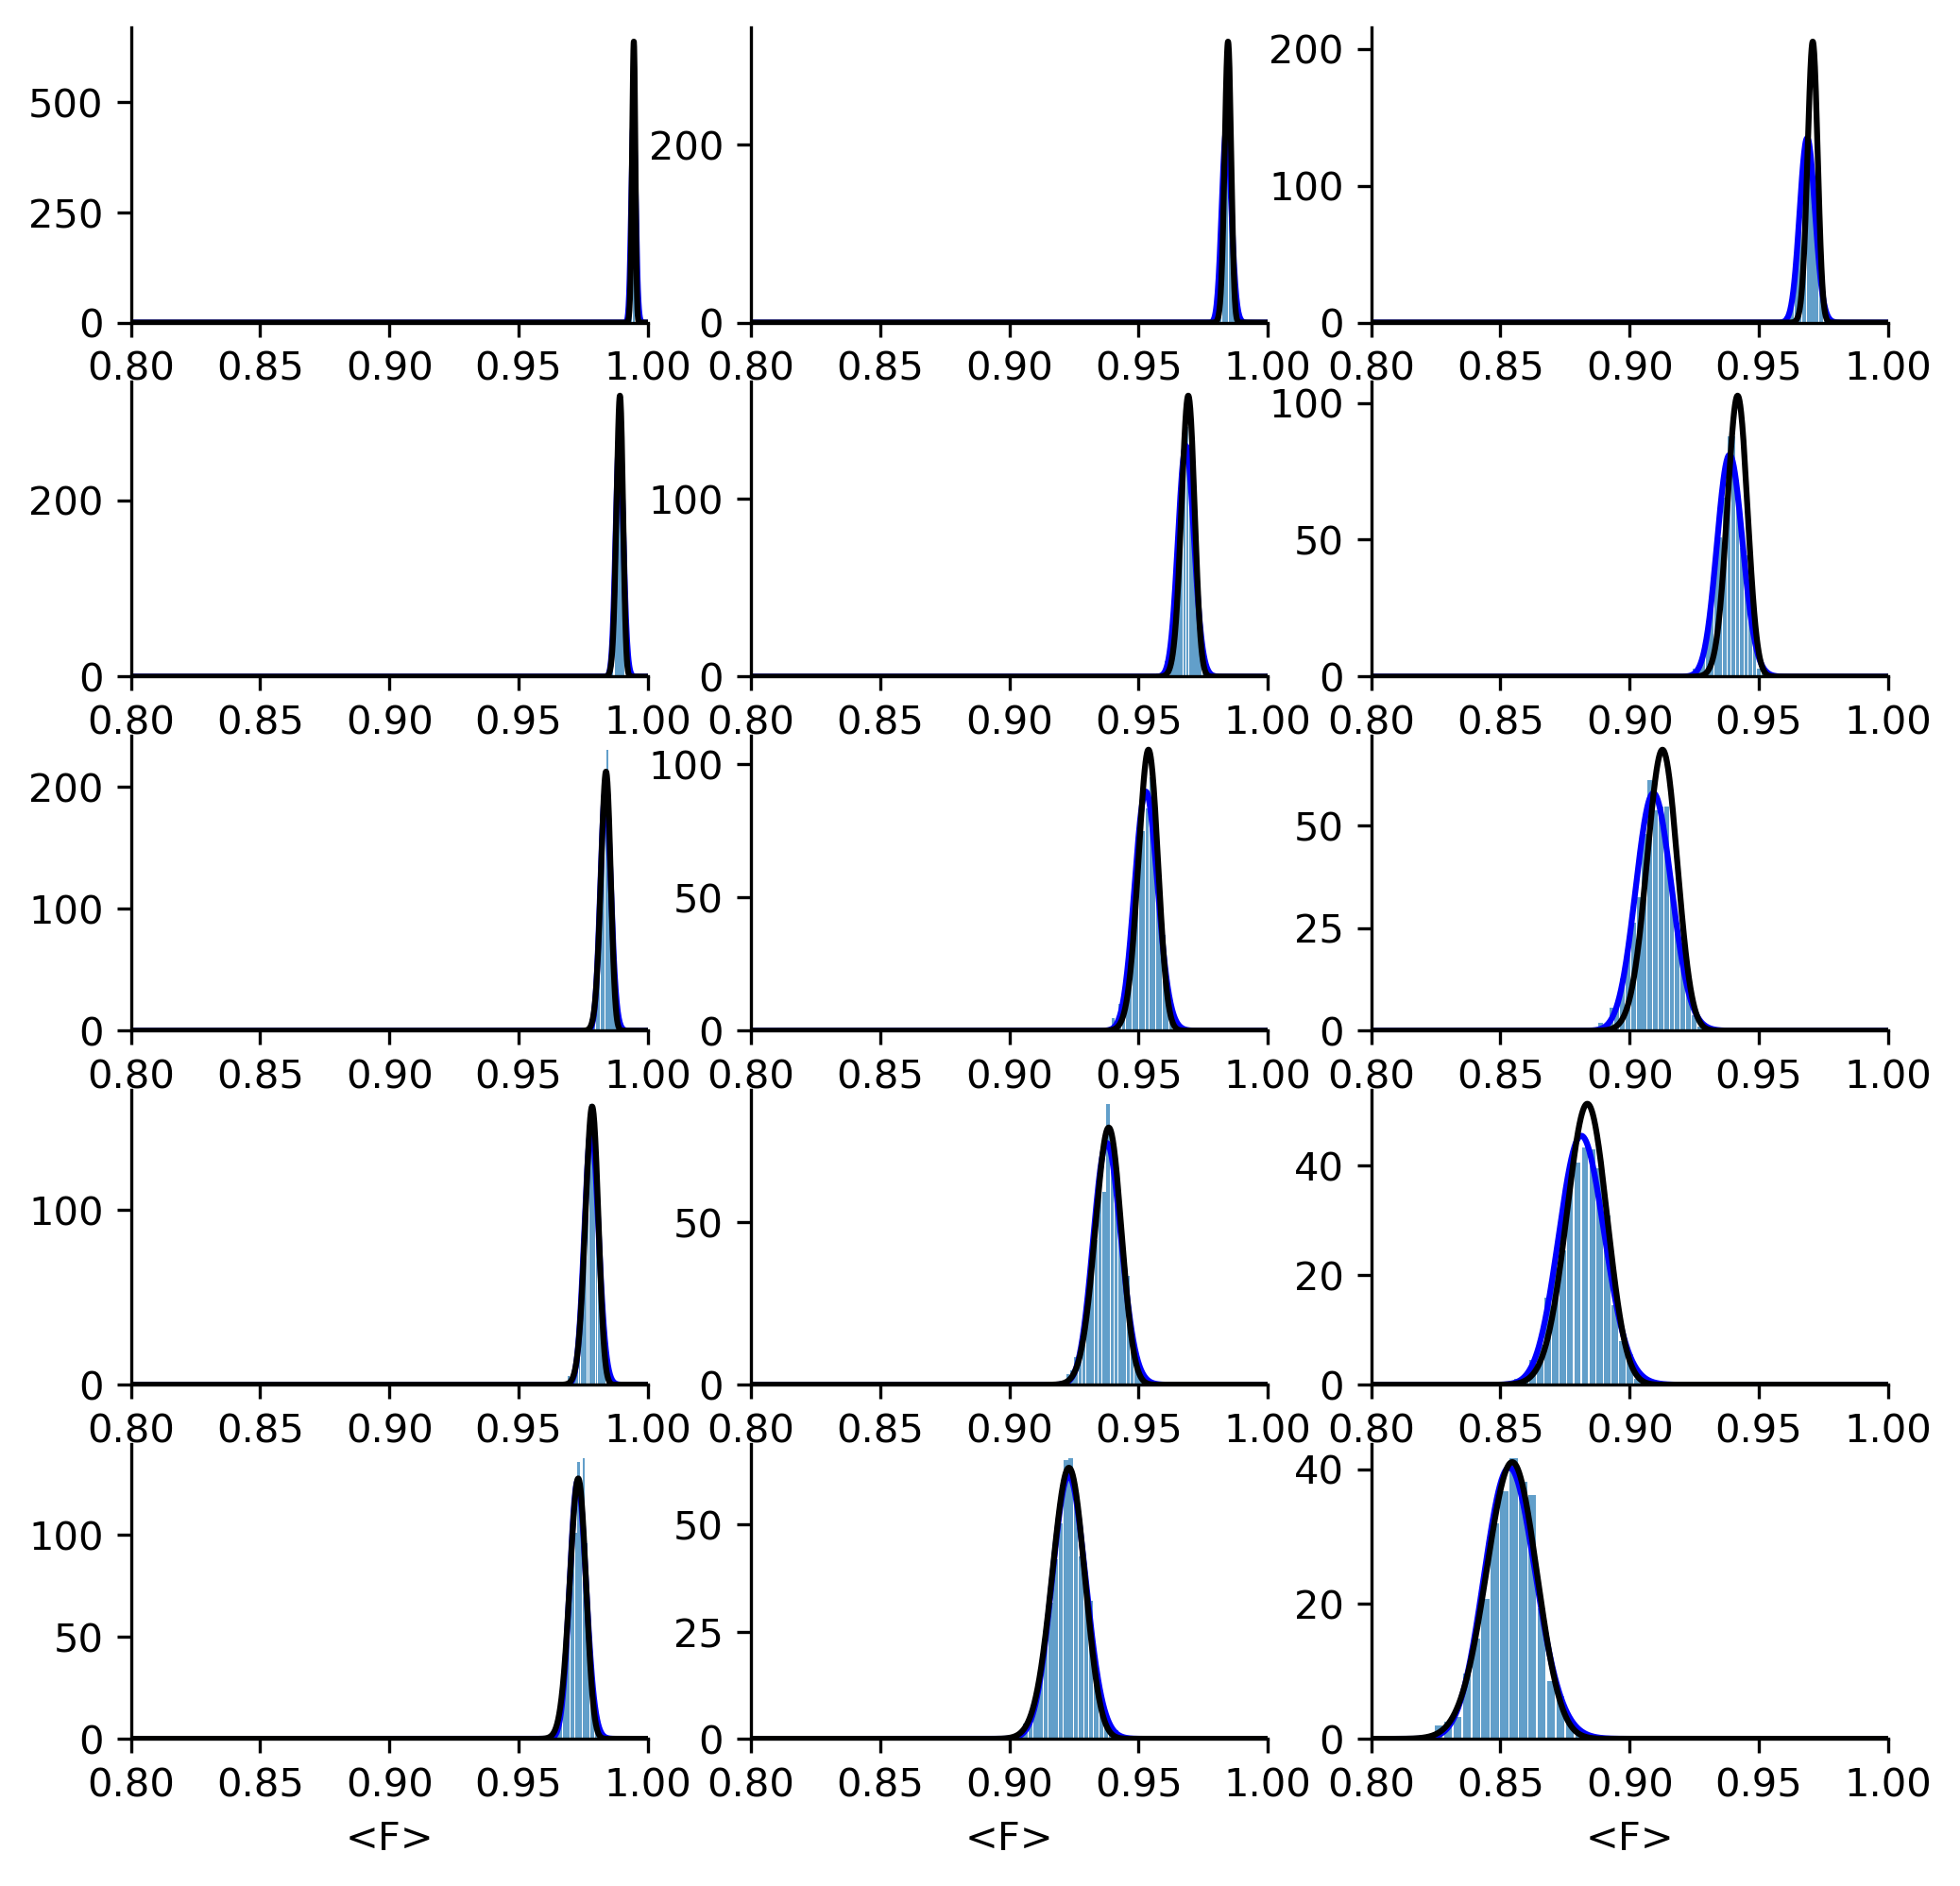

In [27]:
plt.figure(figsize=(8,8),dpi=300)
N_Qubit=1
J_index=4


for N_Qubit in range (1,4):
    for J_index in range(5):
        
        if N_Qubit==1:
            mult=1.212
        
        if N_Qubit==2:
            mult=1.722    
        if N_Qubit==3:
            mult=2.164

        Big_index=(N_Qubit-1)*5+J_index
        ax1 = plt.subplot(5,3,(Big_index%5*3)+Big_index//5+1)  
        ax1.spines["top"].set_visible(False)  
        ax1.spines["right"].set_visible(False)
        plt.hist(results3[Big_index],bins=20,density=1,alpha=0.7,rwidth=0.85)

        sigma2=sigma_error**2
        alpha=N_Qubit*3/2*N
        beta=(2/3)*mult*Js[J_index]*sigma2/N
        x=np.linspace(0,0.2,10000)
        center=1-x+(2/3)*2.2*Js[J_index]*sigma2**2
        x2=np.linspace(0.8,1,1000)

        ag,bg,cg = stats.gamma.fit(results3[Big_index])
        pdf_gamma = stats.gamma.pdf(x2, ag, bg,cg)  
        plt.plot(x2, pdf_gamma, label="Gamma",c='b')

        plt.plot(center,gamma.pdf(x,alpha,0,beta),c='k')
        plt.xlim(0.8,1)
        ax1.set_xlabel("<F>")
plt.savefig('distriMarkovIT.pdf',bbox_inches = 'tight',pad_inches = 0)

In [5]:
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
N_Qubitss=[1,2,3]

path4='results/FinalResults/DCIT-0704-154333.txt'

results4=np.genfromtxt(path4,skip_header=1,delimiter=',')[:,:-1]
means4=np.mean(results4,axis=1)

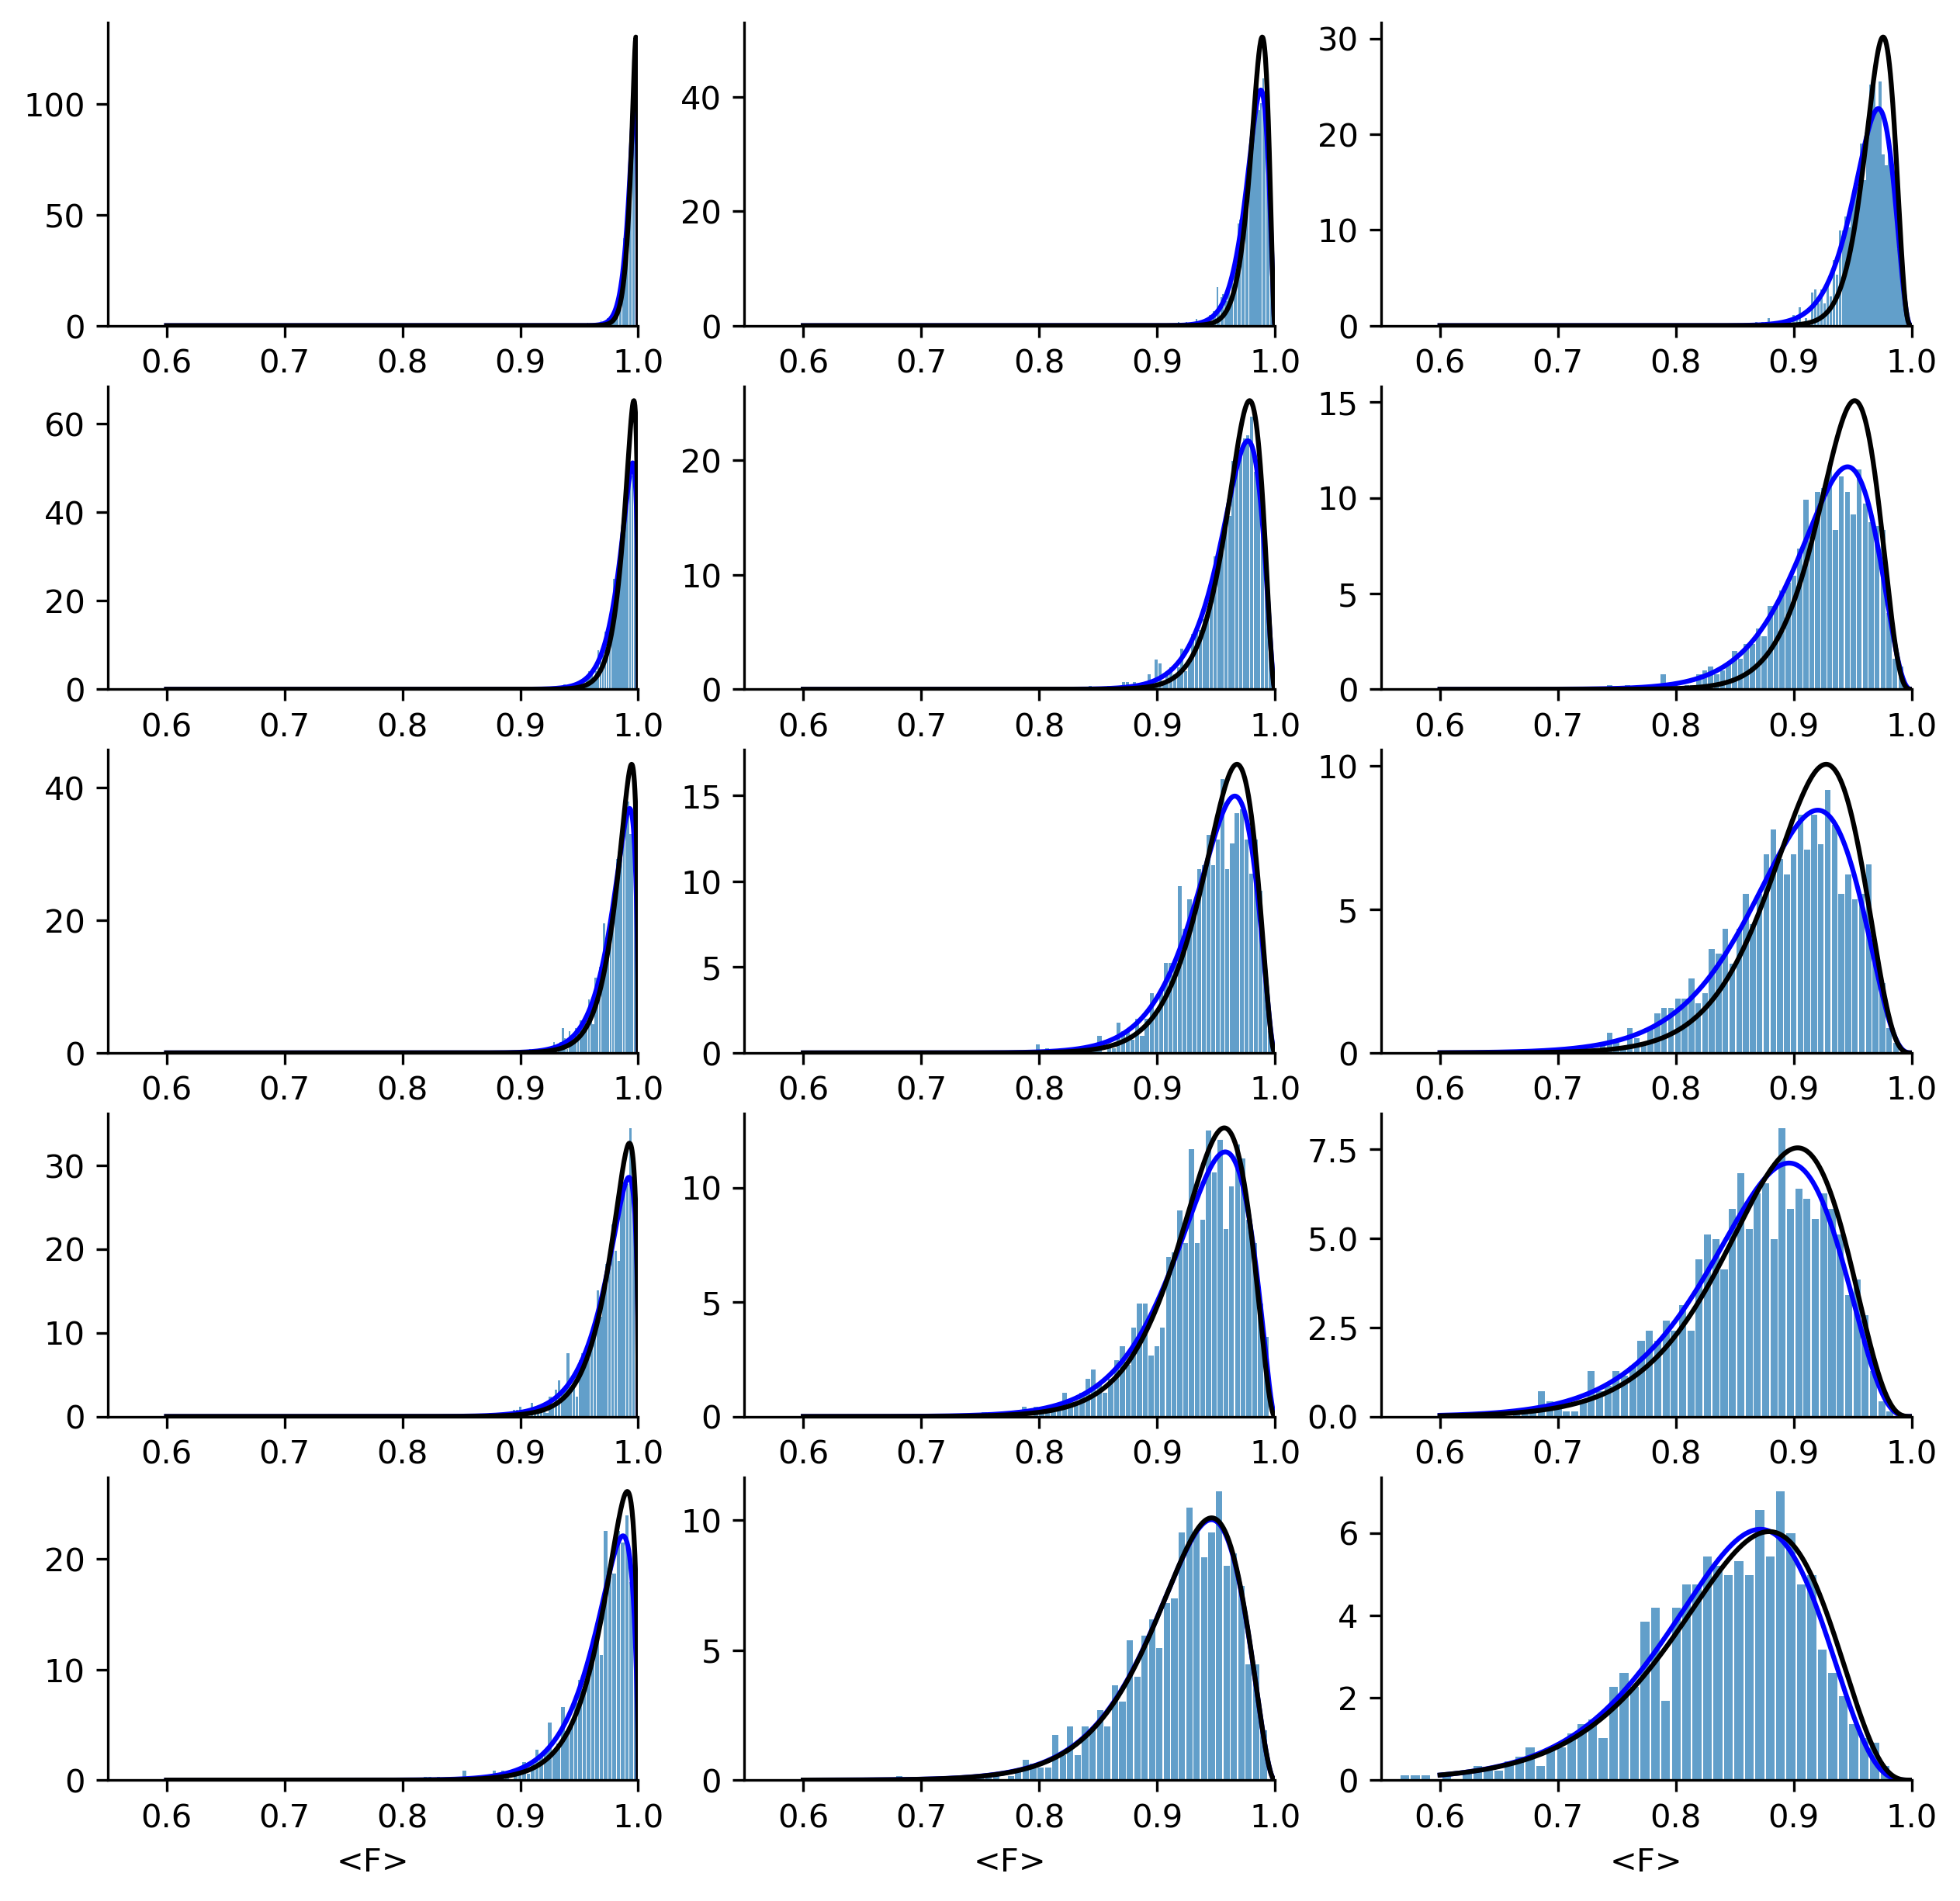

In [28]:
plt.figure(figsize=(10,10),dpi=300)
sigma_error=0.015
Js=[20,40,60,80,100]
N=50
N_Qubitss=[1,2,3]


for N_Qubit in range (1,4):
    for J_index in range(5):
        Big_index=(N_Qubit-1)*5+J_index
        
        if N_Qubit==1:
            mult=1.236
        
        if N_Qubit==2:
            mult=1.789    
        if N_Qubit==3:
            mult=2.302
            
                
        ax1 = plt.subplot(5,3,(Big_index%5*3)+Big_index//5+1)  
        ax1.spines["top"].set_visible(False)  
        ax1.spines["right"].set_visible(False)

        
        plt.hist(results4[Big_index],bins=50,density=1,alpha=0.7,rwidth=0.85)

        sigma2=sigma_error**2
        alpha=N_Qubit*3/2
        beta=(2/3)*mult*Js[J_index]*sigma2

        x=np.linspace(0.6,1,1000)
        y = (1-x)**(alpha-1)*(np.exp(-((1-x)/beta)))*(beta**(-alpha))/sps.gamma(alpha)
        ag,bg,cg = stats.gamma.fit(1-results4[Big_index],floc=0)  
        pdf_gamma = stats.gamma.pdf(1-x, ag, bg,cg)  
        plt.plot(x, pdf_gamma, label="Gamma",c='b')
        plt.plot(x,y,c='k')
        plt.xlim(0.55,1)

        ax1.set_xlabel("<F>")
plt.savefig('distriDCIT.pdf',bbox_inches = 'tight',pad_inches = 0)


-0.0002217 1.0000701
-0.0004428 1.0001571
-0.0006597 1.0000968


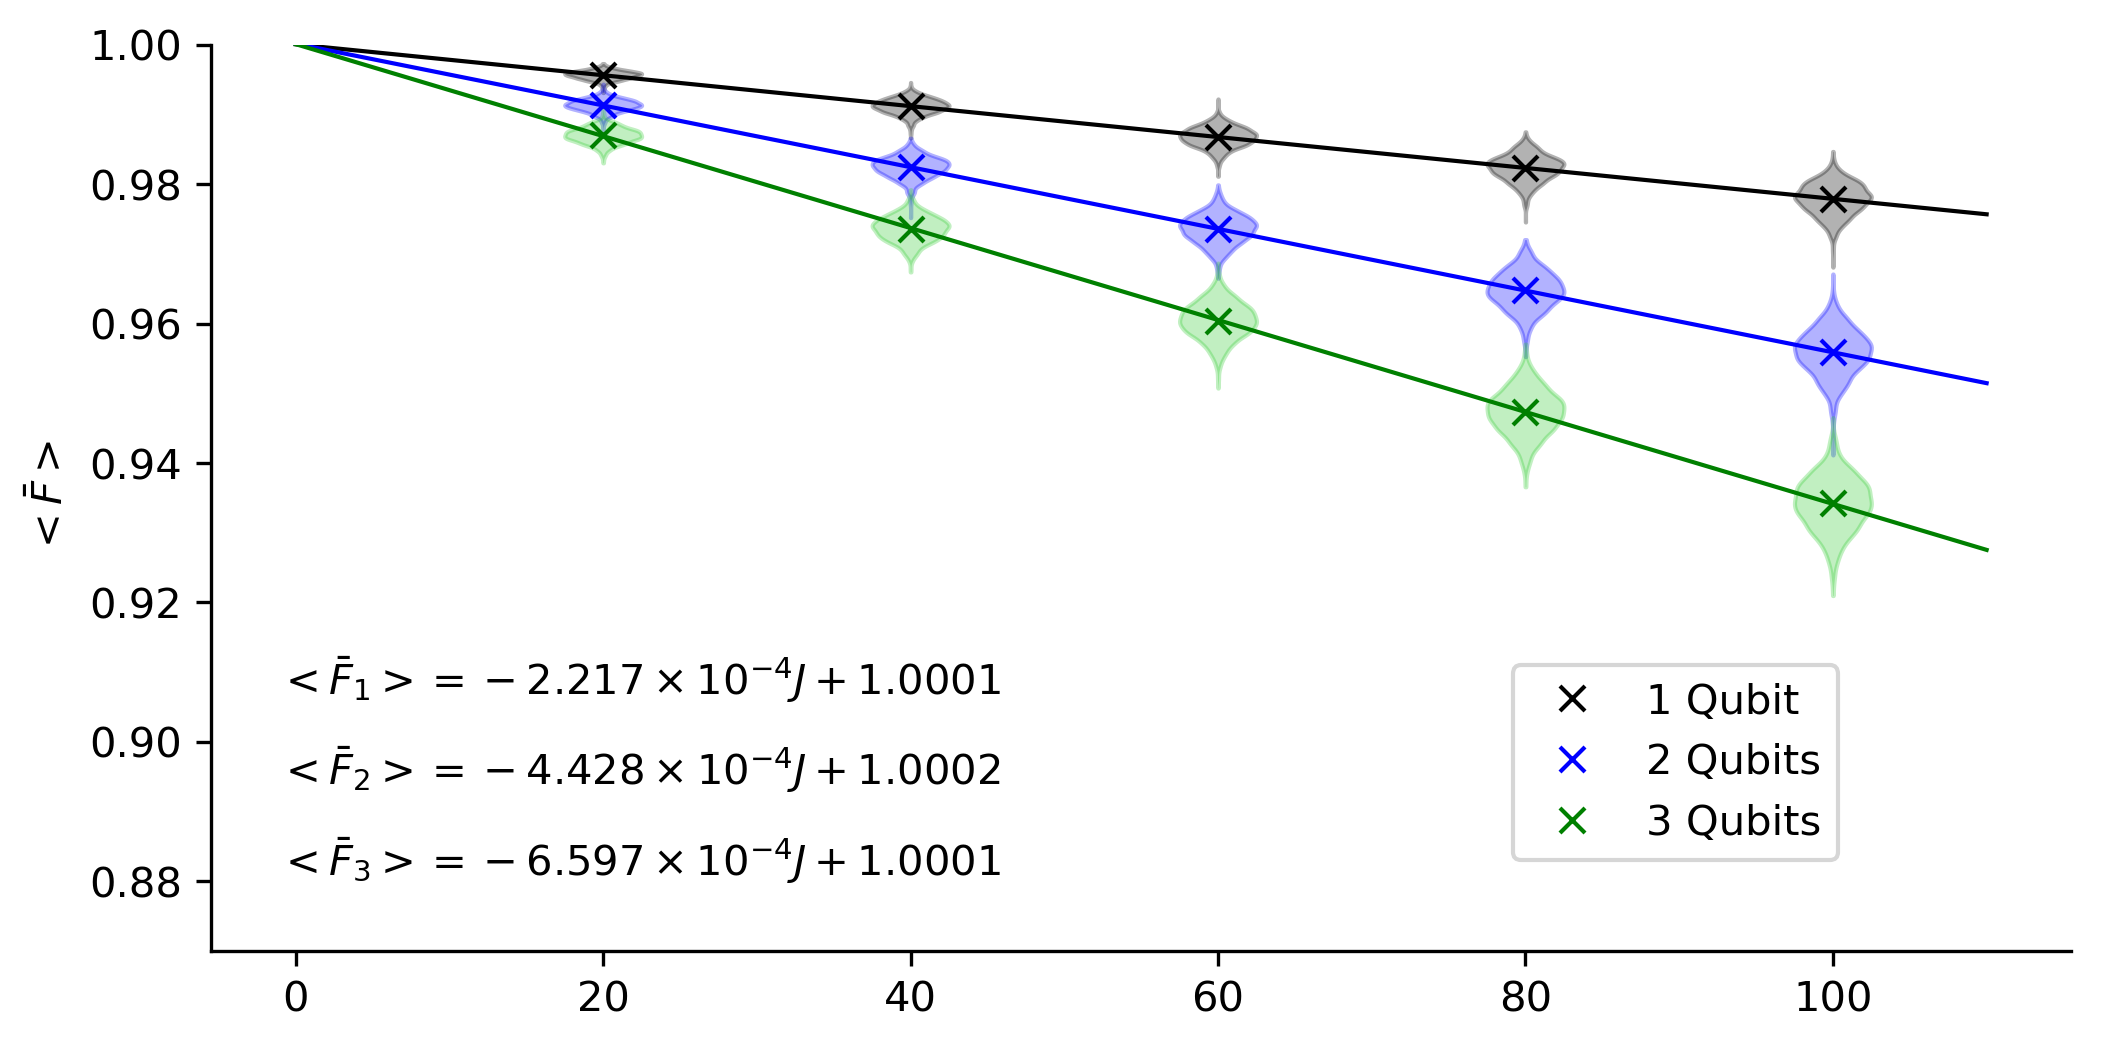

In [23]:
equis=np.linspace(0,110,10)

plt.figure(figsize=(8,4),dpi=300)

ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

plt.plot(Js,means1[0:5],"x",c='k',label='1 Qubit')

y=means1[0:5]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='k',lw=1)

plt.plot(Js,means1[5:10],"x",c='b',label='2 Qubits')

y=means1[5:10]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='b',lw=1)

plt.plot(Js,means1[10:15],"x",c='green',label='3 Qubits')

y=means1[10:15]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='green',lw=1)


violin_parts=plt.violinplot([results1[0],results1[1],results1[2],results1[3],results1[4]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
    
violin_parts=plt.violinplot([results1[5],results1[6],results1[7],results1[8],results1[9]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')

violin_parts=plt.violinplot([results1[10],results1[11],results1[12],results1[13],results1[14]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('limegreen')
    
   

plt.text(0.23, 0.3,r'$<\bar{F}_1>=-2.217\times10^{-4}J+1.0001$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.2,r'$<\bar{F}_2>=-4.428\times10^{-4}J+1.0002$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.1,r'$<\bar{F}_3>=-6.597\times10^{-4}J+1.0001$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.ylim(0.87,1)
plt.legend(loc=(0.7,0.1))
plt.ylabel(r'$<\bar{F}>$')


plt.savefig('FinalTeoMarkovian.pdf',bbox_inches = 'tight',pad_inches = 0)

In [596]:
y=means1[0:5]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print (m,c)

-0.0002216758927307547 1.0000701250427548


-0.0002172 0.9999466
-0.000426 0.9997214
-0.0006227 0.9988924


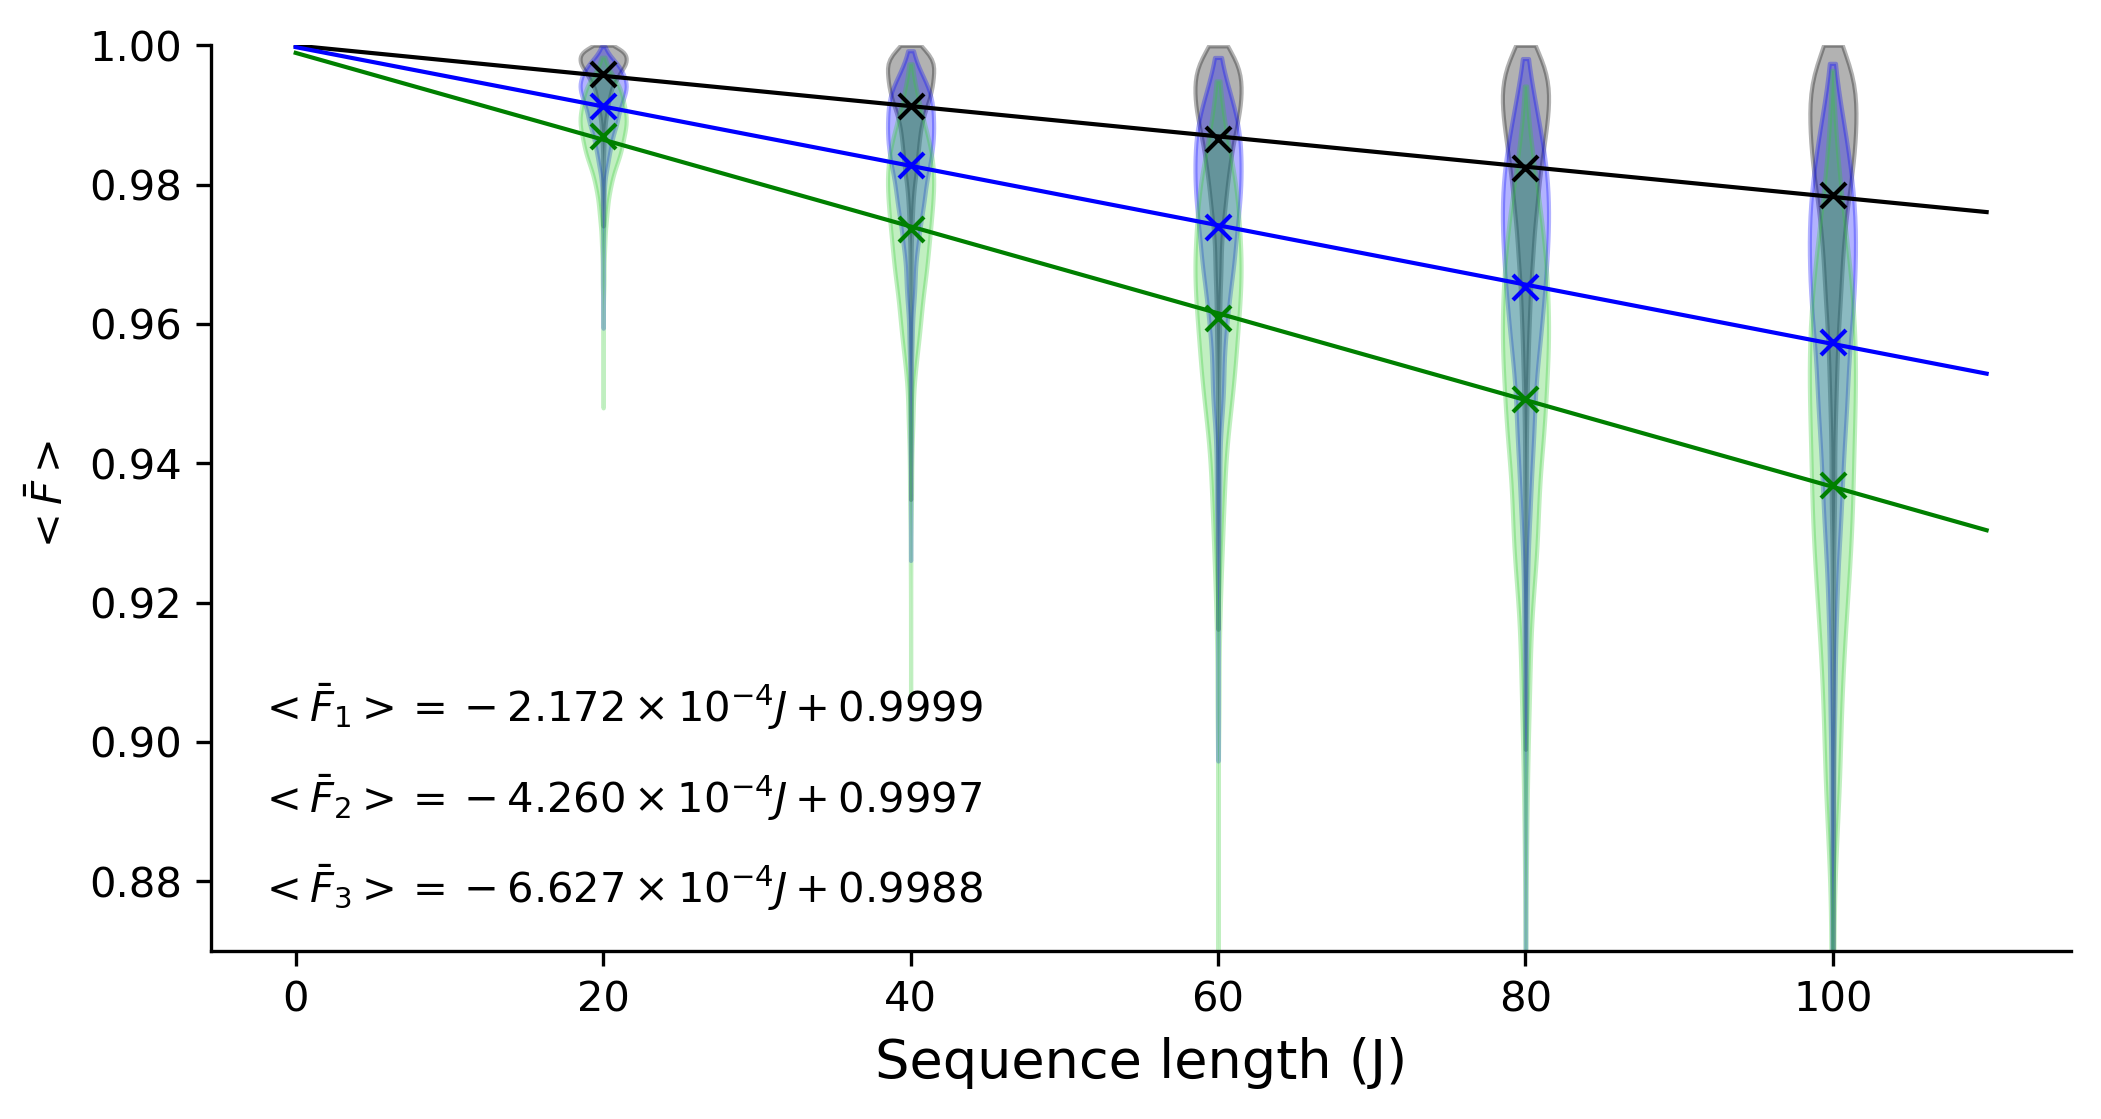

In [58]:
plt.figure(figsize=(8,4),dpi=300)


ax2 = plt.subplot(111)  
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False) 

plt.plot(Js,means2[0:5],"x",c='k',label='1 Qubit')

y=means2[0:5]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

plt.plot(equis,equis*m+c,c='k',lw=1)

print(round(m,7),round(c,7))

plt.plot(Js,means2[5:10],"x",c='b',label='2 Qubits')


y=means2[5:10]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

plt.plot(equis,equis*m+c,c='b',lw=1)

print(round(m,7),round(c,7))

plt.plot(Js,means2[10:15],"x",c='green',label='3 Qubits')

y=means2[10:15]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

plt.plot(equis,equis*m+c,c='green',lw=1)

print(round(m,7),round(c,7))

violin_parts=plt.violinplot([results2[0],results2[1],results2[2],results2[3],results2[4]],[20,40,60,80,100],widths=3,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
    
violin_parts=plt.violinplot([results2[5],results2[6],results2[7],results2[8],results2[9]],[20,40,60,80,100],widths=3,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')

violin_parts=plt.violinplot([results2[10],results2[11],results2[12],results2[13],results2[14]],[20,40,60,80,100],widths=3,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('limegreen')

    
plt.text(0.22, 0.27,r'$<\bar{F}_1>=-2.172\times10^{-4}J+0.9999$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax2.transAxes)

plt.text(0.22, 0.17,r'$<\bar{F}_2>=-4.260\times10^{-4}J+0.9997$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax2.transAxes)

plt.text(0.22, 0.07,r'$<\bar{F}_3>=-6.627\times10^{-4}J+0.9988$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax2.transAxes)

plt.ylim(0.87,1)

plt.xlabel('Sequence length (J)',size=13)
plt.ylabel(r'$<\bar{F}>$')

plt.savefig('FinalTeoDC.pdf',bbox_inches = 'tight',pad_inches = 0)

-0.0002685 0.9998807
-0.0007623 0.9990819
-0.0014338 0.9967391


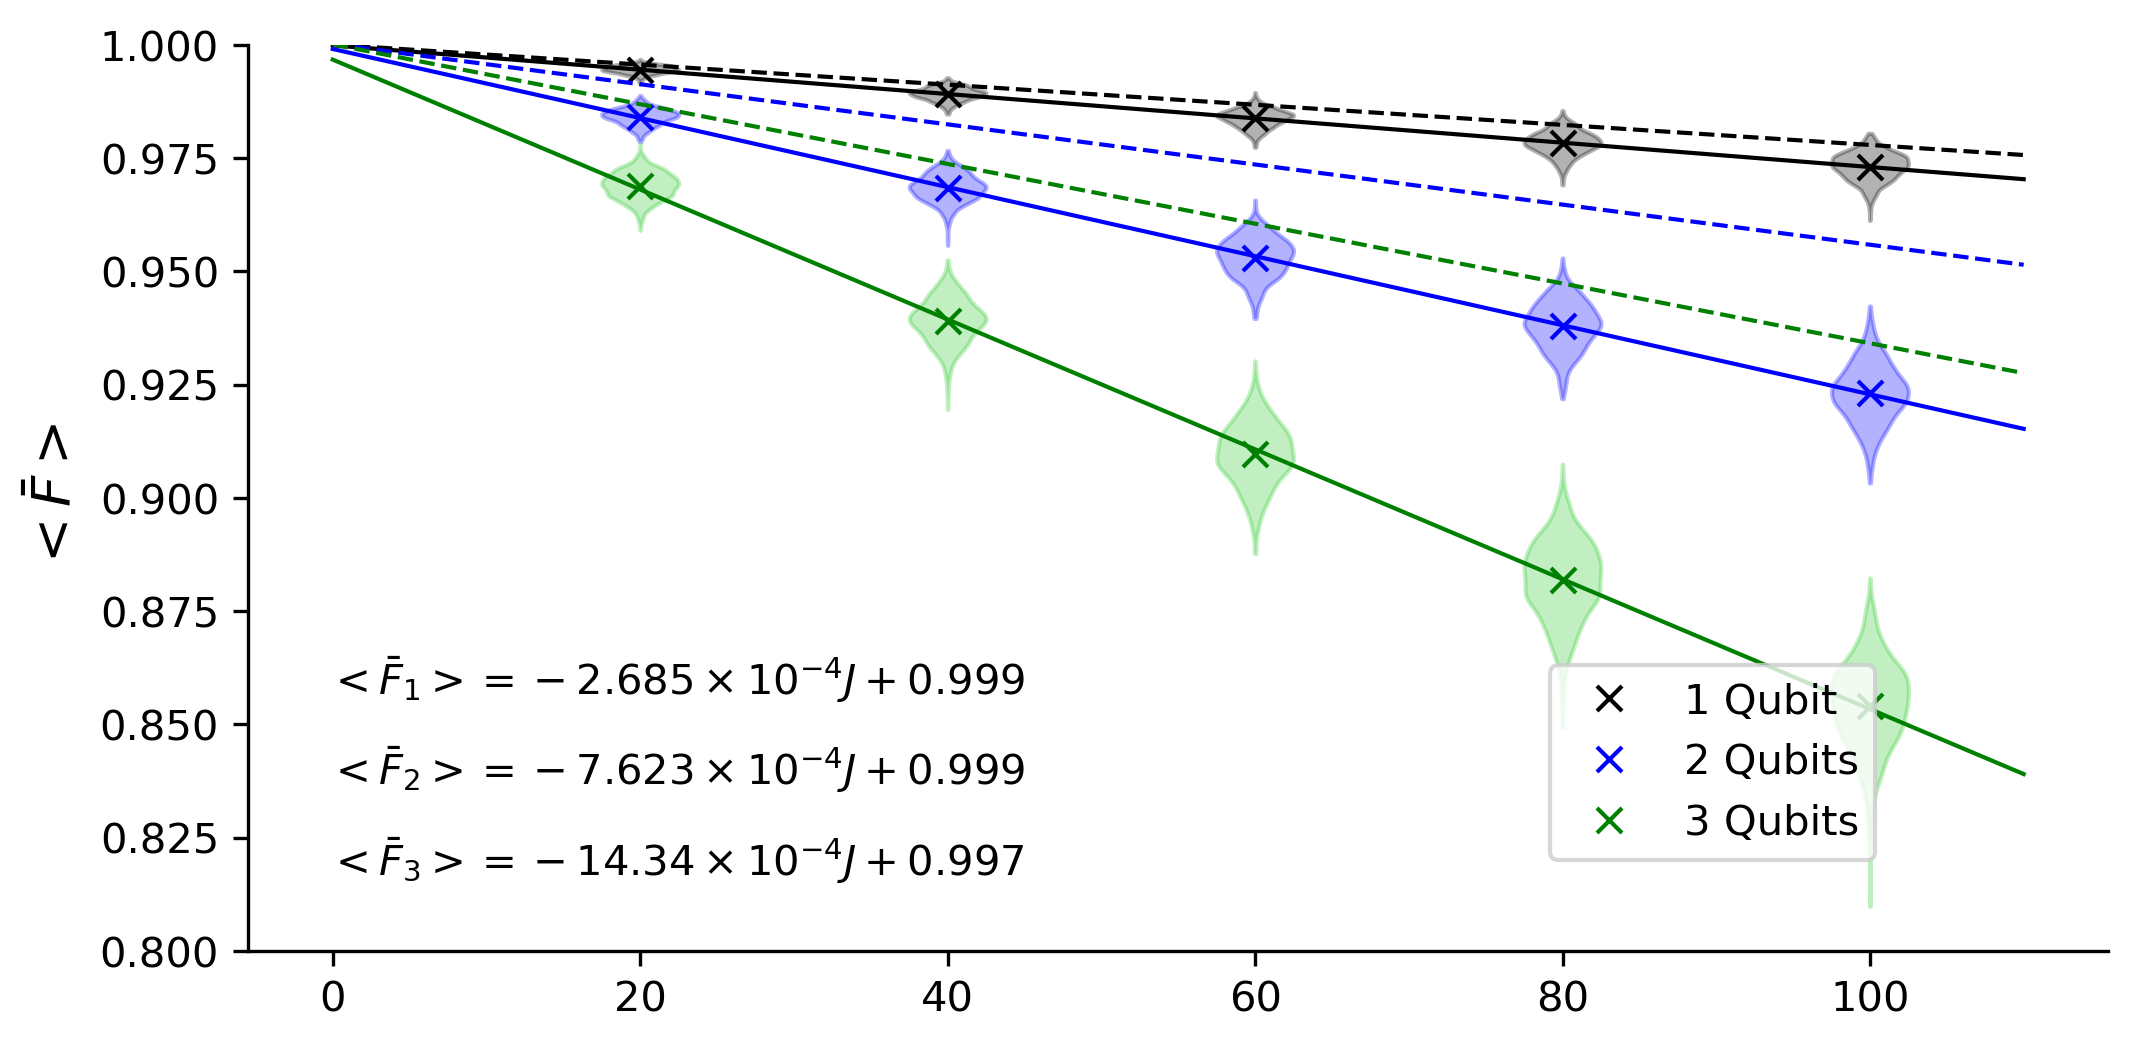

In [33]:
equis=np.linspace(0,110,10)

plt.figure(figsize=(8,4),dpi=300)

ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

plt.plot(Js,means3[0:5],"x",c='k',label='1 Qubit')

y=means3[0:5]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='k',lw=1)

plt.plot(Js,means3[5:10],"x",c='b',label='2 Qubits')

plt.plot(equis,-0.0002217*equis+ 1.0000701,"--",c='k',lw=1)

# 
# 

y=means3[5:10]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='b',lw=1)

plt.plot(Js,means3[10:15],"x",c='green',label='3 Qubits')

plt.plot(equis,-0.0004428*equis+ 1.0001571,"--",c='b',lw=1)


y=means3[10:15]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='green',lw=1)

plt.plot(equis,-0.0006597*equis+ 1.0000968,"--",c='g',lw=1)

violin_parts=plt.violinplot([results3[0],results3[1],results3[2],results3[3],results3[4]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
    
violin_parts=plt.violinplot([results3[5],results3[6],results3[7],results3[8],results3[9]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')

violin_parts=plt.violinplot([results3[10],results3[11],results3[12],results3[13],results3[14]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('limegreen')
    
   

plt.text(0.23, 0.3,r'$<\bar{F}_1>=-2.685\times10^{-4}J+0.999$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.2,r'$<\bar{F}_2>=-7.623\times10^{-4}J+0.999$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.1,r'$<\bar{F}_3>=-14.34\times10^{-4}J+0.997$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.ylim(0.8,1)
plt.legend(loc=(0.7,0.1))
plt.ylabel(r'$<\bar{F}>$',size=13)


plt.savefig('FinalITMarkovian.pdf',bbox_inches = 'tight',pad_inches = 0)

In [60]:
print(0.0002685/0.0002172)
print(0.0007623/0.000426)
print(0.0014338/0.0006227)



1.2361878453038675
1.78943661971831
2.3025533964991167


-0.0003154 0.999129
-0.0007758 0.9951117
-0.0015098 0.988055


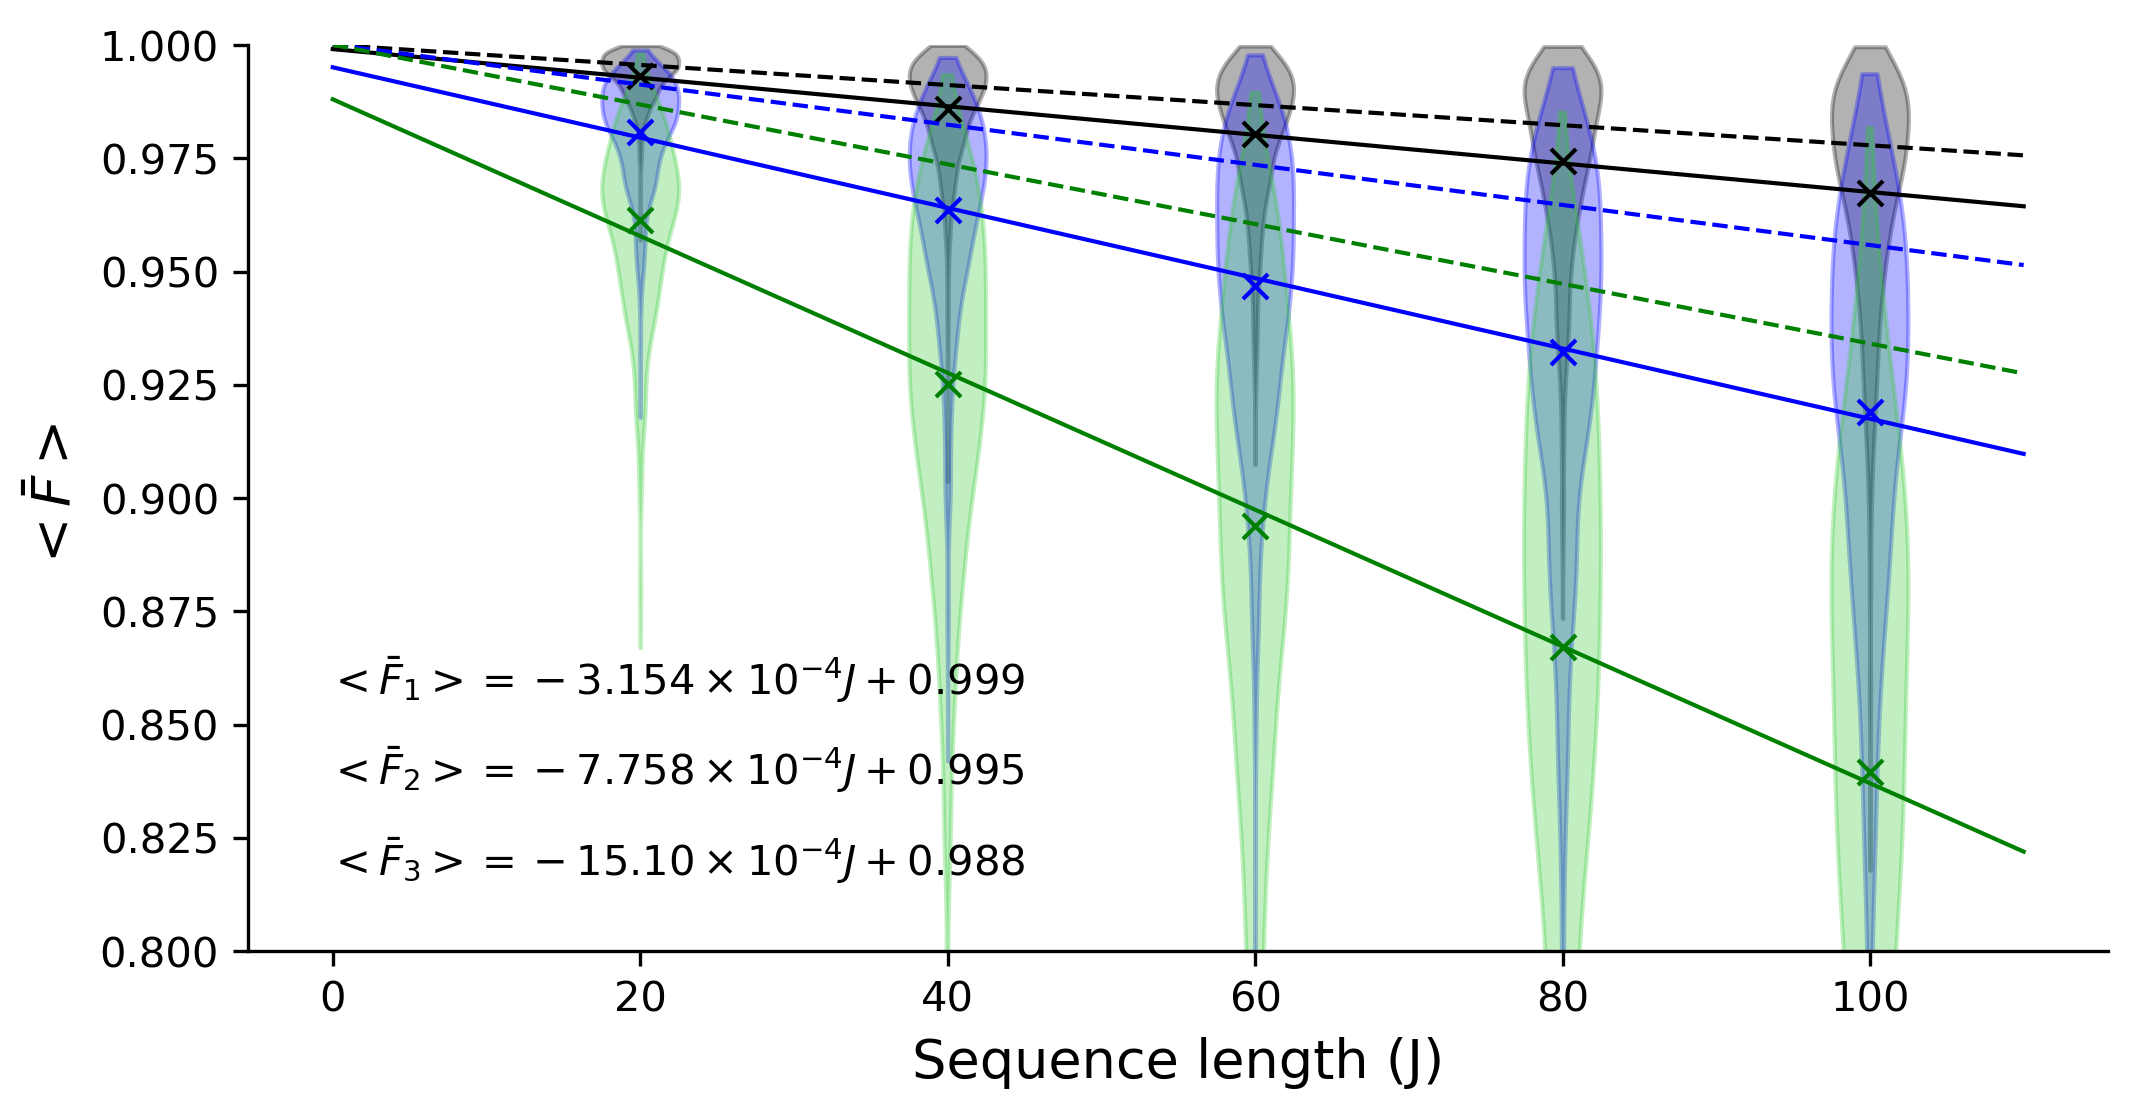

In [32]:
equis=np.linspace(0,110,10)

plt.figure(figsize=(8,4),dpi=300)

ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

plt.plot(Js,means4[0:5],"x",c='k',label='1 Qubit')

y=means4[0:5]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='k',lw=1)

plt.plot(Js,means4[5:10],"x",c='b',label='2 Qubits')

plt.plot(equis,-0.0002217*equis+ 1.0000701,"--",c='k',lw=1)

y=means4[5:10]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='b',lw=1)

plt.plot(Js,means4[10:15],"x",c='green',label='3 Qubits')

plt.plot(equis,-0.0004428*equis+ 1.0001571,"--",c='b',lw=1)


y=means4[10:15]
m, c = np.linalg.lstsq(np.array([Js,[1,1,1,1,1]]).T, y, rcond=None)[0]

print(round(m,7),round(c,7))

plt.plot(equis,equis*m+c,c='green',lw=1)

plt.plot(equis,-0.0006597*equis+ 1.0000968,"--",c='g',lw=1)

violin_parts=plt.violinplot([results4[0],results4[1],results4[2],results4[3],results4[4]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
    
violin_parts=plt.violinplot([results4[5],results4[6],results4[7],results4[8],results4[9]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')

violin_parts=plt.violinplot([results4[10],results4[11],results4[12],results4[13],results4[14]],[20,40,60,80,100],widths=5,showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('limegreen')
    
   

plt.text(0.23, 0.3,r'$<\bar{F}_1>=-3.154\times10^{-4}J+0.999$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.2,r'$<\bar{F}_2>=-7.758\times10^{-4}J+0.995$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.text(0.23, 0.1,r'$<\bar{F}_3>=-15.10\times10^{-4}J+0.988$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax1.transAxes)

plt.ylim(0.8,1)

plt.ylabel(r'$<\bar{F}>$',size=13)

plt.xlabel('Sequence length (J)',size=13)
plt.savefig('FinalITDC.pdf',bbox_inches = 'tight',pad_inches = 0)

# Interleaved

In [13]:
theta = Parameter('theta')
delta = Parameter('delta') 
u_x=np.array([[quil_cos((theta+delta)/2),1j*quil_sin((theta+delta)/2)],
              [1j*quil_sin((theta+delta)/2),quil_cos((theta+delta)/2)]])

u_z=np.array([[quil_cos((theta+delta)/2)+1j*quil_sin((theta+delta)/2),0],
              [0,-1j*quil_sin((theta+delta)/2)+quil_cos((theta+delta)/2)]])


U_x_definition = DefGate('U_x', u_x, [theta,delta])
U_x = U_x_definition.get_constructor()

U_z_definition = DefGate('U_z', u_z, [theta,delta])
U_z = U_z_definition.get_constructor()

o_4=np.array([[quil_cos(theta),0,0,1j*quil_sin(theta)],
     [0,quil_cos(theta),1j*quil_sin(theta),0],
     [0,1j*quil_sin(theta),quil_cos(theta),0],
     [1j*quil_sin(theta),0,0,quil_cos(theta)]])

O4_definition = DefGate('O_4', o_4, [theta])
O_4 = O4_definition.get_constructor()

In [63]:
def generate_interleaved_sequence(length,full_p,indexes,deltas,deltas2,N_Qubits):    

    full_p+=noise_z_definition
    
    program=[]
    inverse=Program()
    
    for indexx,deltaa,delta2 in zip(indexes,deltas,deltas2):
        for qubit in range(N_Qubits):
            
            index=indexx[qubit]
            delta=deltaa[qubit]
        
            noise=Noise_z(delta)(qubit)
            program.append(noise)
            program.append(cliffords_to_program(index,qubit))
            inverse+=cliffords_to_program(index,qubit)
            noise2=Noise_z(delta2)(qubit)
            program.append(noise2)
            
        
        program.append(CNOT(0,1))
        inverse+=CNOT(0,1)
        
    full_p+=program 
    full_p+=inverse.dagger()
    
    return full_p

## Markovian

In [60]:
def interleaved_markovian_theoretical(sigma_error,sigma_error2,J,N_Qubits,trials,N,path):
    final=[]    
    for i in tqdm_notebook(range(trials)):
        indexes=np.random.randint(0,24,(J,N_Qubits)) 
        results=[]
        for j in range (N):
            deltas=np.random.normal(0,sigma_error,(J,N_Qubits))
            deltas2=np.random.normal(0,sigma_error2,(J))
            correction=np.sum(deltas**2)
            p=generate_interleaved_sequence(J,Program(),indexes,deltas,deltas2,N_Qubits)
            wf_sim = WavefunctionSimulator()
            wavefunction = wf_sim.wavefunction(p)
            results.append(abs(wavefunction[0])**2-(1/3)*correction)
        final.append(np.mean(results))
    write_data(final,path)


In [89]:
sigma_error=0.015
sigma_error2=0.015
Js=[40]
N=50
trials=100
N_Qubitss=[2]

timestr = time.strftime("%m%d-%H%M%S")
path5='results/Harris2/In-markovian-'+timestr+".txt"


with open(path5, 'w') as the_file:
    the_file.write('N='+str(N)+' J = '+str(Js)+' NQ = '+str(N_Qubitss)+' sigma = '+str(sigma_error)+'\n')


In [90]:
for N_Qubits in N_Qubitss:
    for J in Js:
        interleaved_markovian_theoretical(sigma_error,sigma_error2,J,N_Qubits,trials,N,path5)

In [91]:
tessst=np.genfromtxt(path5,delimiter=',',skip_header=1)[:-1]

tessst


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [88]:
3*(1-(0.00084/0.000225))/4

-2.05

In [ ]:


p=Program()
p+=U_x_definition
p+=U_z_definition
p+=O4_definition

#p+=X(1)
p+=X(0)

p+=U_x(np.pi/2,0)(0)
p+=U_x(np.pi/2,0)(1)

p+=U_z(np.pi/2,0)(0)

p+=O_4(np.pi/8)(0,1)

p+=U_x(np.pi/2,0)(0)
p+=U_x(np.pi/2,0)(1)

p+=O_4(np.pi/8)(0,1)

p+=U_z(np.pi/2,0)(0)

p+=U_x(np.pi/2,0)(0)
p+=U_x(np.pi/2,0)(1)



p+=CNOT(0,1).dagger()


wf_sim = WavefunctionSimulator()
wavefunction = wf_sim.wavefunction(p)
print(wavefunction)

qc = get_qc('2q-qvm')
result = qc.run_and_measure(p, trials=1)
print(result[0])
print(result[1])



In [34]:
p=Program()

p+=X(0)
p+=X(1)
p+=X(2)
p+=X(0)
#p+=RX(np.pi,0)
#p+=RX(np.pi,1)
#p+=CNOT(1,0)
wf_sim = WavefunctionSimulator()
wavefunction = wf_sim.wavefunction(p)

print(wavefunction)

qc = get_qc('3q-qvm')
result = qc.run_and_measure(p, trials=10)
print(result[0])
print(result[1])
print(result[2])

(1+0j)|110>
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


In [22]:
print(p)

X 0
X 1
X 2
X 0



# Bayesian method!

In [76]:
def beta_distribution(data,alpha,prior_alpha,prior_beta):
    
    post_alpha=prior_alpha+len(data)*alpha
    post_beta=prior_beta+np.sum(data)
    x=np.linspace(0,0.01,1000)
    pdf_beta = stats.invgamma.pdf(x,post_alpha,0,post_beta)
    
    return pdf_beta

In [77]:
data1= np.random.gamma(3/2, 2/3*0.015**2, 100)

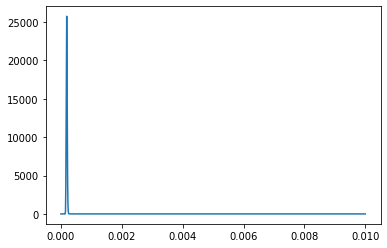

In [78]:
plt.plot(np.linspace(0,0.01,1000),beta_distribution(data1,3/2,1,30*0.015**2))

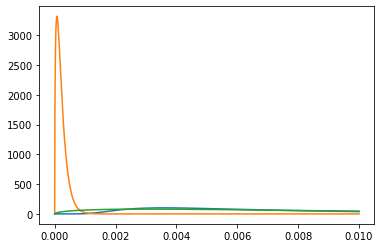

In [79]:
x=np.linspace(0,0.01,1000)
ag,bg,cg = stats.gamma.fit(data1,floc=0)  
plt.plot(x,stats.invgamma.pdf(np.linspace(0,0.01,1000),3/2,0,40*0.015**2))
plt.plot(x,stats.gamma.pdf(x,ag,bg,cg))
#plt.plot(x,beta_distribution(data1,3/2,3/2,40*0.015**2))
plt.plot(x,stats.gamma.pdf(x,3/2,0,2/3*40*0.015**2))

In [9]:
def MLE(data,alpha,beta):
    return (alpha-1)*np.sum(np.log(data))-np.sum(data/beta)-len(data)*alpha*np.log(beta)-len(data)*np.log(sps.gamma(alpha))



In [7]:
def bayesian_estimation(data,M,prior,Js,alphas,betas,Theoretical=True):
    
    if Theoretical:
        a=2000
    
    else:
        a=1000
    
    points=np.random.randint(0,a,M)
    
    one_qubit=1-data[0:5,points]
    two_qubit=1-data[5:10,points]
    three_qubit=1-data[10:15,points]
    
    data1=[]
    data2=[]
    data3=[]
    for i in range (len(Js)):
        data1+=list(one_qubit[i,:]/Js[i])
        data2+=list(two_qubit[i,:]/Js[i])
        data3+=list(three_qubit[i,:]/Js[i])

    likel1=np.array([[MLE(np.array(data1),a,b) for b in betas[0]] for a in alphas[0]])
    likel2=np.array([[MLE(np.array(data2),a,b) for b in betas[1]] for a in alphas[1]])
    likel3=np.array([[MLE(np.array(data3),a,b) for b in betas[2]] for a in alphas[2]])
    
    X1,Y1=np.meshgrid(betas[0],alphas[0])
    pos1 = np.empty(X1.shape + (2,))
    pos1[:, :, 0] = X1; pos1[:, :, 1] = Y1
    rv1 = stats.multivariate_normal([0.0002, 1.5], [[0.000001, 0], [0, 0.01]])
    prior1=rv1.pdf(pos1)
    
    X2,Y2=np.meshgrid(betas[1],alphas[1])
    pos2 = np.empty(X2.shape + (2,))
    pos2[:, :, 0] = X2; pos2[:, :, 1] = Y2
    rv2 = stats.multivariate_normal([0.0002, 3], [[0.000001, 0], [0, 0.01]])
    prior2=rv2.pdf(pos2)
    
    X3,Y3=np.meshgrid(betas[2],alphas[2])
    pos3 = np.empty(X3.shape + (2,))
    pos3[:, :, 0] = X3; pos3[:, :, 1] = Y3
    rv3 = stats.multivariate_normal([0.0002, 4.5], [[0.000001, 0], [0, 0.01]])
    prior3=rv3.pdf(pos1)
    
    
    return likel1,prior1,likel2,prior2,likel3,prior3

In [36]:
alphas=[np.linspace(0.01,3,1000),np.linspace(1,5,1000),np.linspace(1,5,1000)]

betas=[np.linspace(0.00001,0.001,1000),np.linspace(0.00001,0.001,1000),np.linspace(0.00001,0.001,1000)]


test=bayesian_estimation(results2,100,1,Js,alphas,betas)

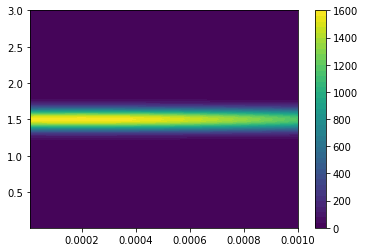

In [92]:
x=np.linspace(0.00001,0.001,1000)
x2=np.linspace(0.01,3,1000)
X,Y=np.meshgrid(x,x2)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = stats.multivariate_normal([0.0002, 1.5], [[0.000001, 0], [0, 0.01]])
prior=rv.pdf(pos)
plt.contourf(X, Y, rv.pdf(pos),40)
plt.colorbar()

(1e-05, 0.0004)

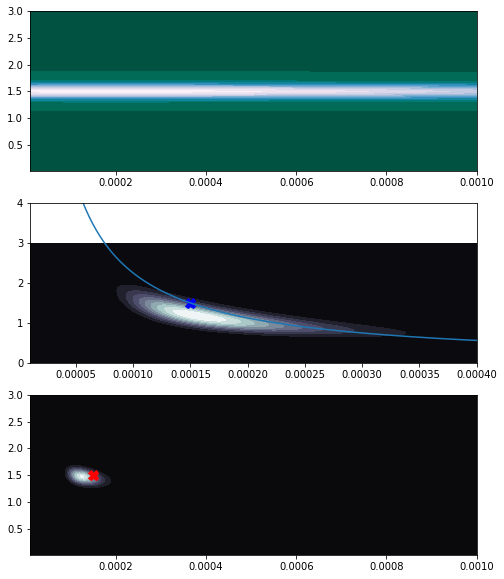

In [105]:
plt.figure(figsize=(8,10))
x=betas[0]
x2=alphas[0]
plt.subplot(3,1,3)
plt.contourf(x,x2,np.exp(test[0]-np.max(test[0])+np.log(test[1])),10,cmap='bone')
plt.plot([(2/3)*0.000225],[1.5],'X',ms=10,c='r')

plt.subplot(3,1,1)
plt.contourf(x,x2,np.exp(np.log(test[1])),10,cmap='bone')

plt.subplot(3,1,2)
plt.contourf(x,x2,np.exp(test[0]-np.max(test[0])),10,cmap='bone')
plt.plot([(2/3)*0.000225],[1.5],'X',ms=10,c='b')

plt.plot(x,0.000225/x)
plt.ylim(0,4)
plt.xlim(0.00001,0.0004)

In [37]:
def plot_pdf (x,x2,data):

    # Create Fig and gridspec
    fig = plt.figure(figsize=(8, 6), dpi= 300)
    grid = plt.GridSpec(7, 7, hspace=0.01, wspace=0.01)

    # Define the axes
    ax_main = fig.add_subplot(grid[1:-1, :-1])
    ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
    ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

    # Scatterplot on main ax
    ax_main.contourf(x,x2,data,10,cmap='Greys')
    ax_main.set_xlim(0.00001,0.0004)
    ax_main.plot([(2/3)*0.000225],[1.5],'X',ms=7,c='b')
    
    ax_main.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax_main.set_ylabel(r'$\alpha$',size=14)
    ax_main.set_xlabel(r'$\beta$',size=14)
    ax_main.tick_params(axis='both', which='major', labelsize=12)

    max_a,max_b=np.unravel_index(data.argmax(), data.shape)
    
    ax_main.plot(x[max_b],x2[max_a],'X',ms=7,c='r')
    
    ax_main.text(0.76, 0.27,r'$\hat{\alpha}$='+str(round(x2[max_a],3)), horizontalalignment='center',verticalalignment='center', transform=ax_main.transAxes,size=12)
    ax_main.text(0.76, 0.17,r'$\hat{\beta}$='+str(round(x[max_b]*10000,3))+r'$\times10^{-4}$', horizontalalignment='center',verticalalignment='center', transform=ax_main.transAxes,size=12)
        
    # histogram on the right
    ax_top.plot(x,np.sum(data,axis=0),c='k')
    ax_top.axis('off')
    ax_top.set_xlim(0.00001,0.0004)
    ax_top.fill([0.00001]+list(x)+[0.0004],[0]+list(np.sum(data,axis=0))+[0], facecolor='k', edgecolor='k', linewidth=1,alpha=0.3)

    # histogram in the bottom
    ax_right.plot(np.sum(data,axis=1),x2,c='k')
    ax_right.fill([0]+list(np.sum(data,axis=1)),[3]+list(x2), facecolor='k', edgecolor='k', linewidth=1,alpha=0.3)
    ax_right.axis('off') 
    ax_right.set_ylim(0,3)
    
    #x_right.invert_xaxis()

    # Decorations
    #ax_main.set(title='Scatterplot with Histograms \n displ vs hwy', xlabel='displ', ylabel='hwy')
    #ax_main.title.set_fontsize(20)
   # for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    #    item.set_fontsize(14)

    #xlabels = ax_main.get_xticks().tolist()
    #ax_main.set_xticklabels(xlabels)
    #plt.show()

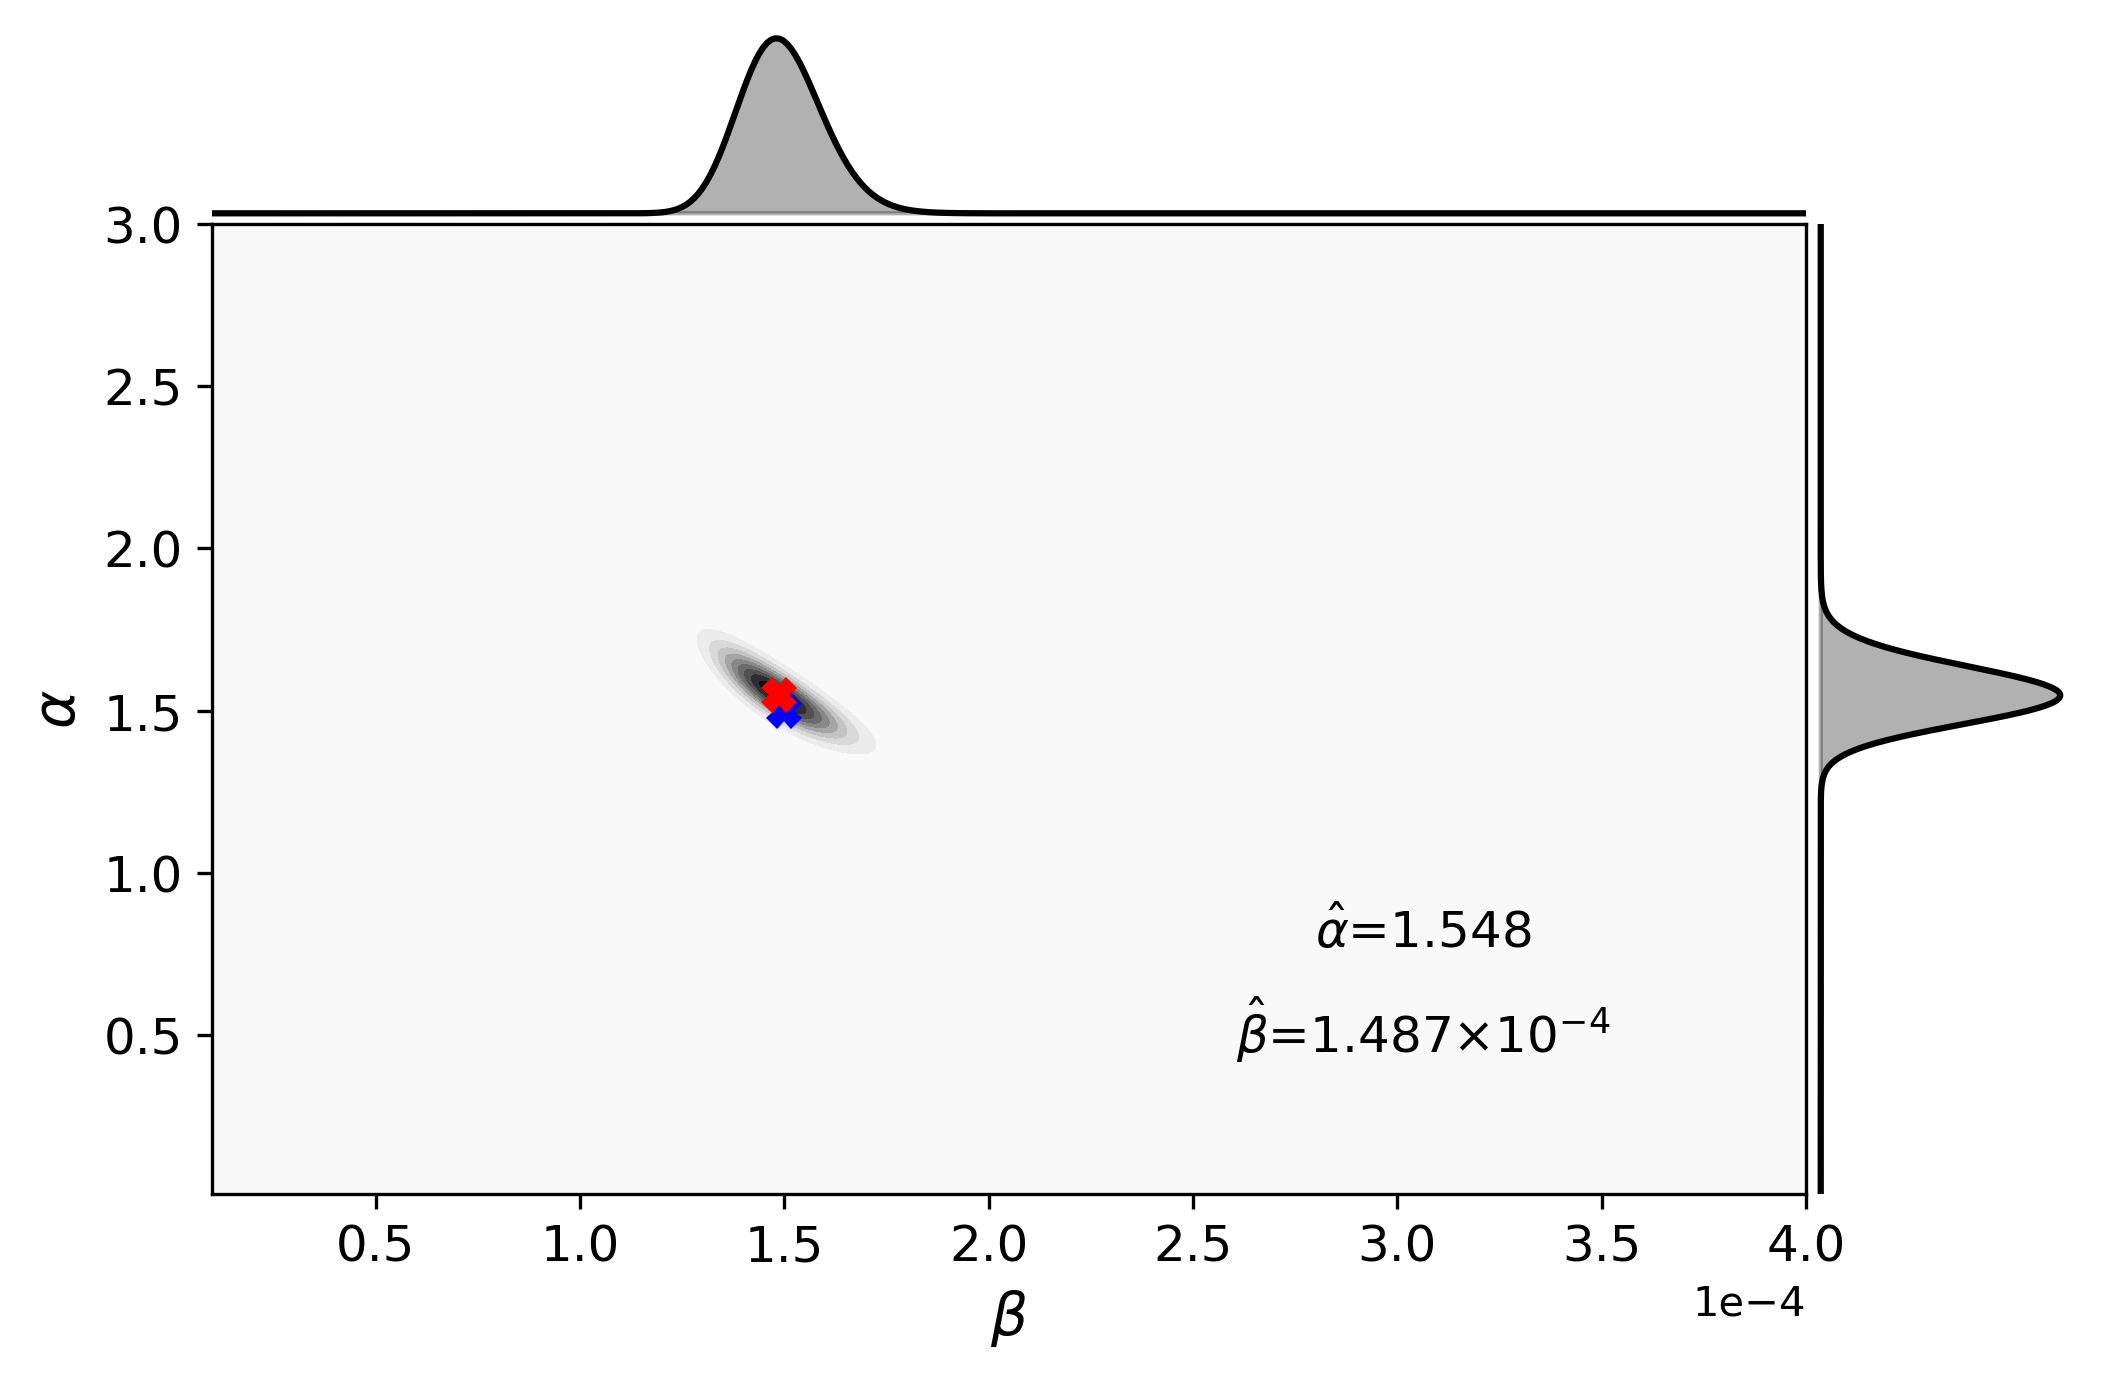

In [38]:
x=betas[0]
x2=alphas[0]
plot_pdf(x,x2,np.exp(test[0]-np.max(test[0])))
plt.savefig('Bayesian1Q100DLikel3.pdf',bbox_inches = 'tight',pad_inches = 0)

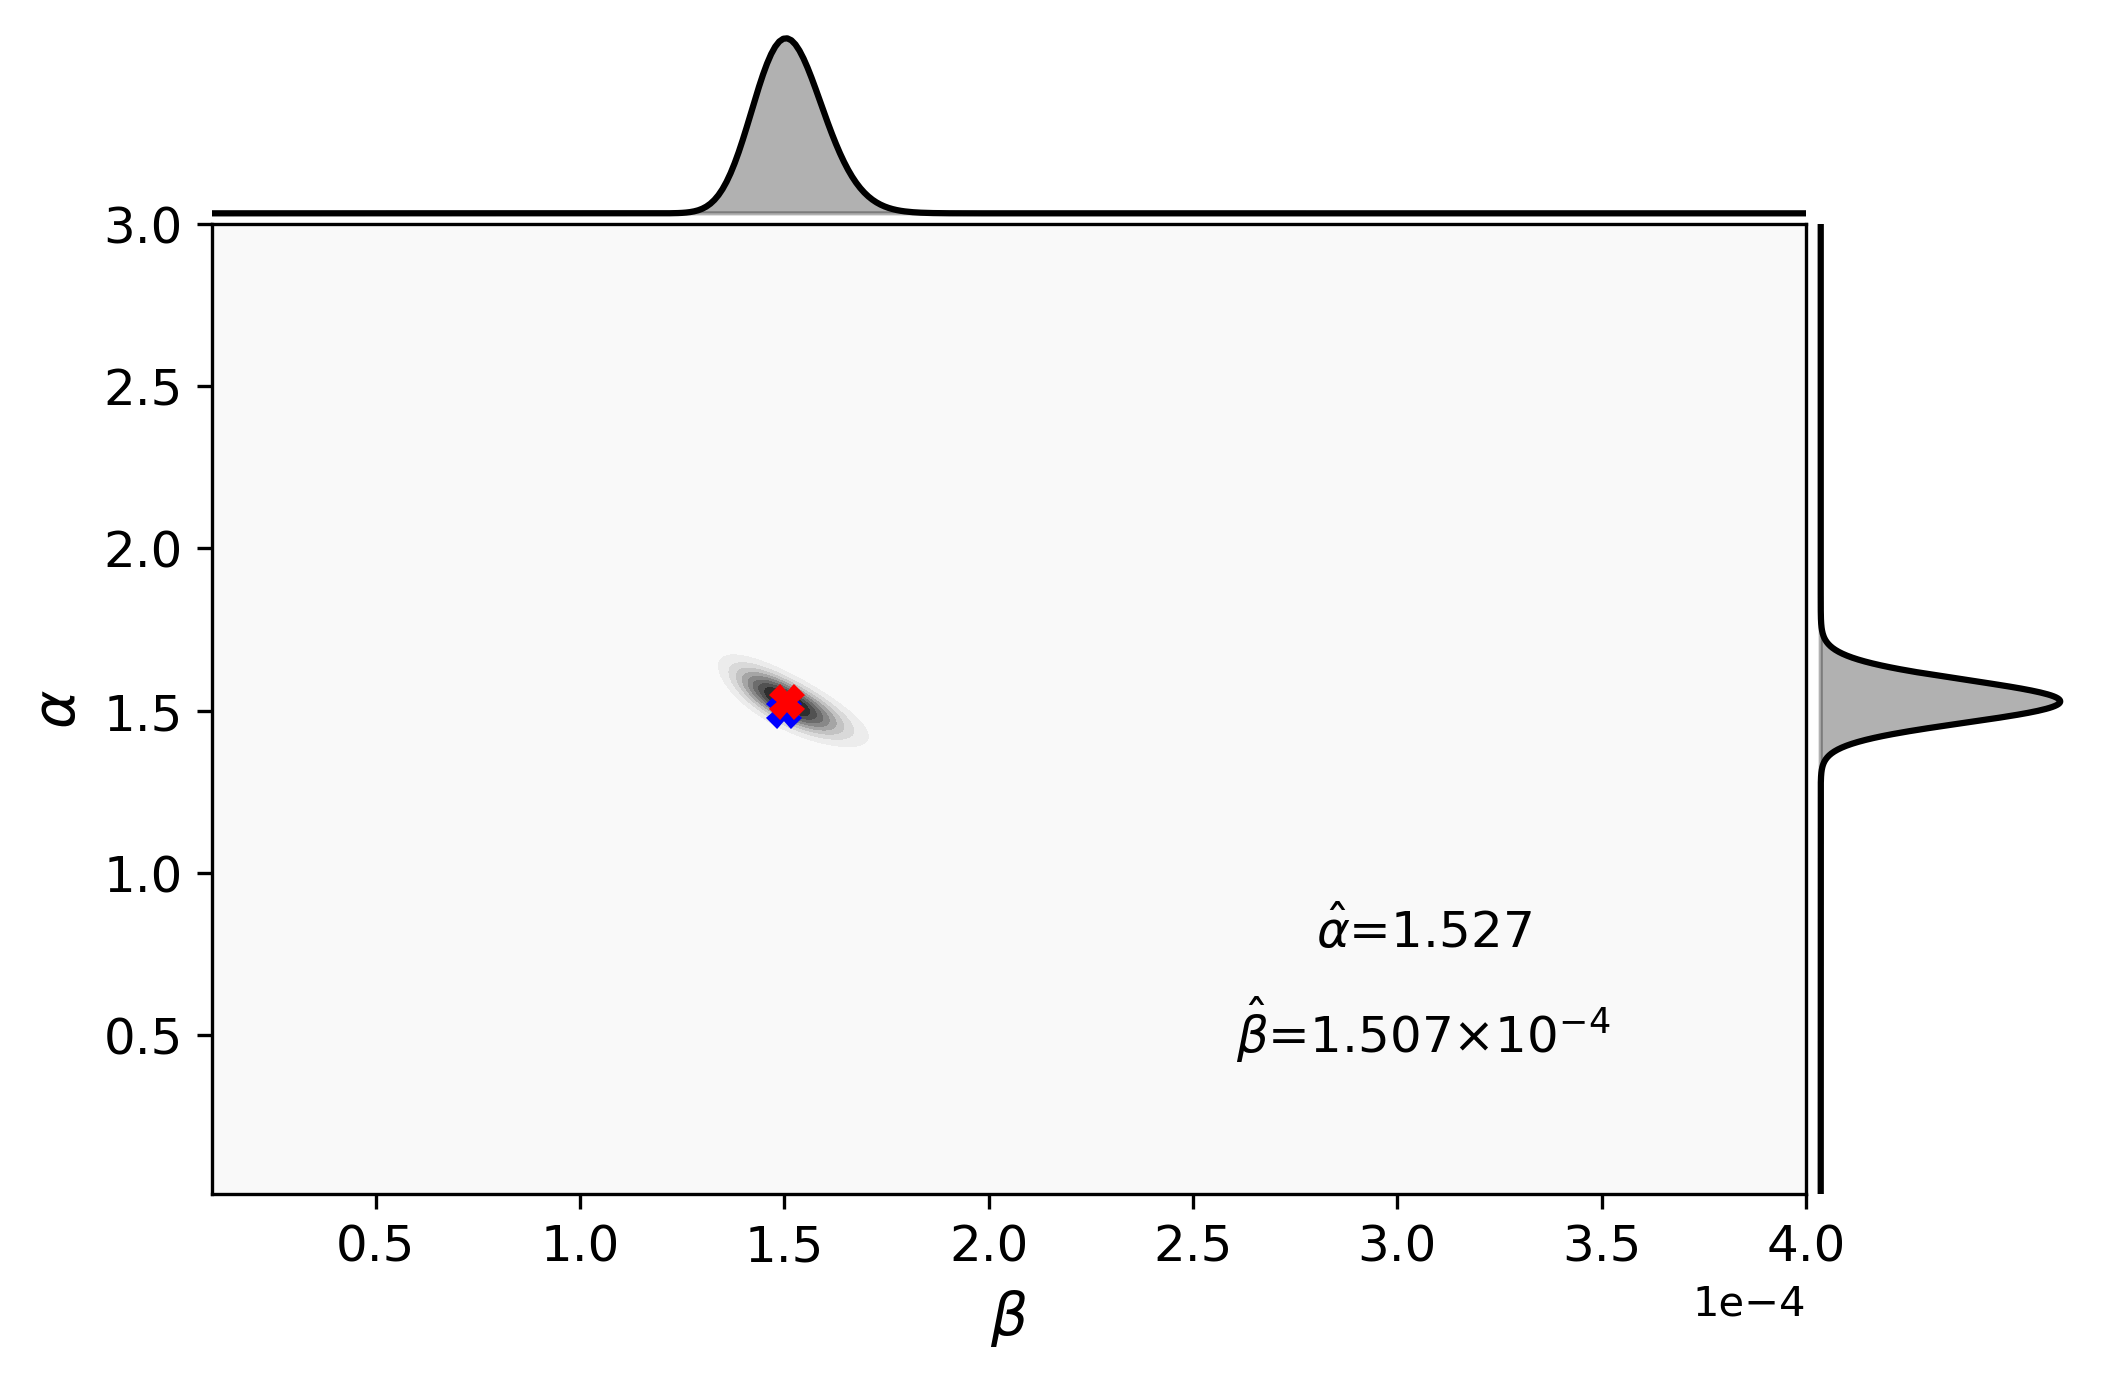

In [39]:
plot_pdf(x,x2,np.exp(test[0]-np.max(test[0])+np.log(test[1])))
plt.savefig('Bayesian1Q100DPosterior3.pdf',bbox_inches = 'tight',pad_inches = 0)

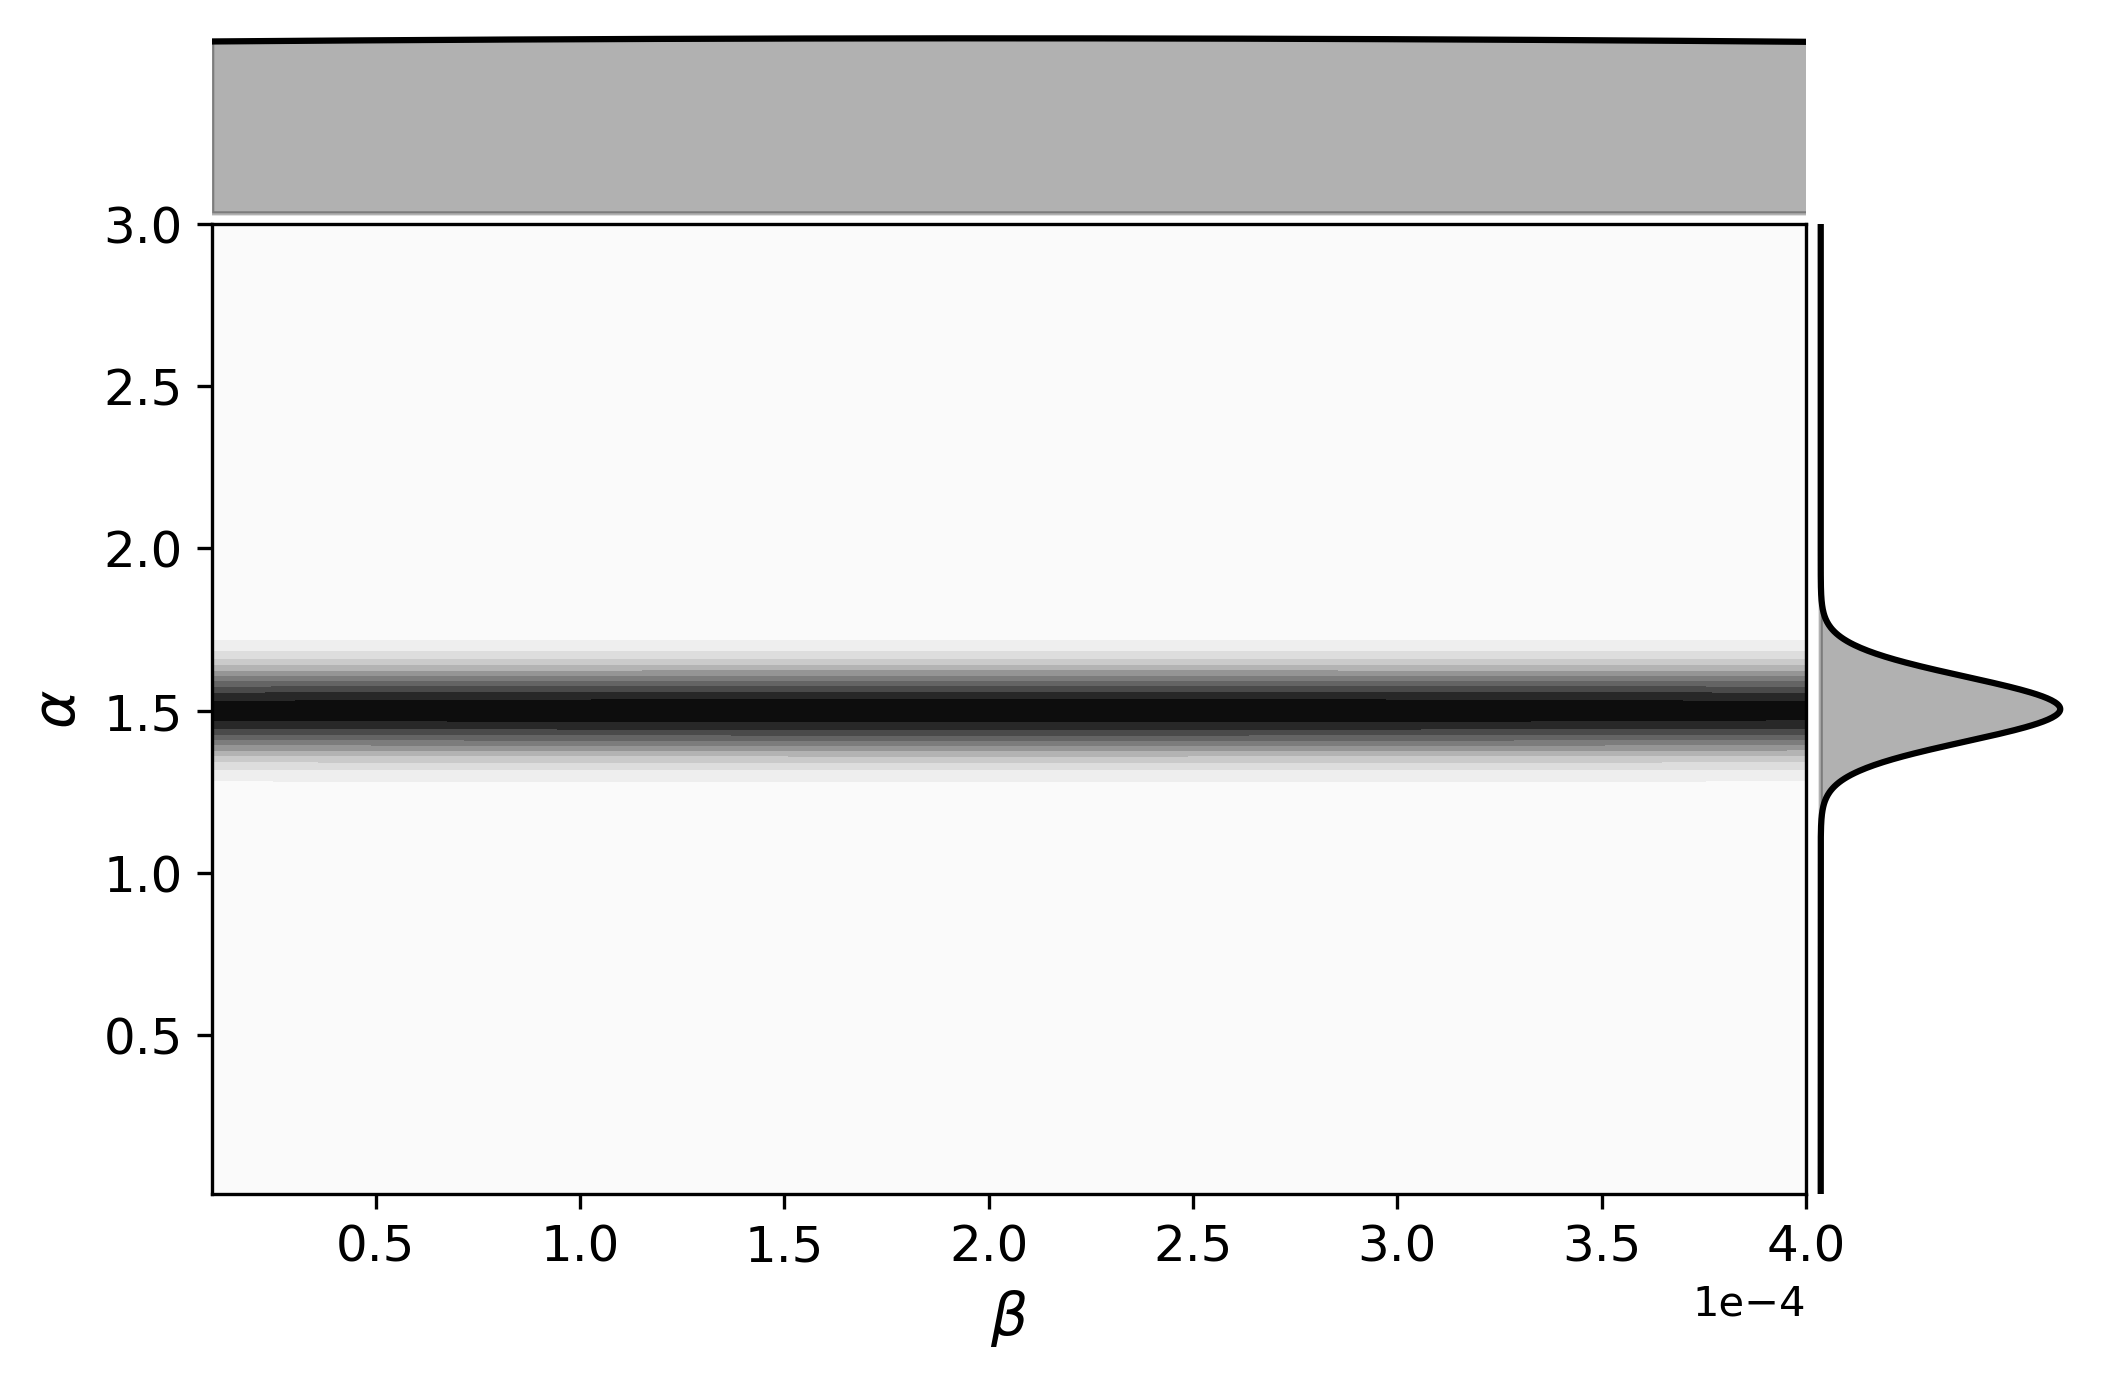

In [428]:
plot_pdf(x,x2,np.exp(np.log(test[1])))
plt.savefig('Bayesian1Qprior.pdf',bbox_inches = 'tight',pad_inches = 0)

In [872]:
points=np.random.randint(0,2000,10)

one_qubit=1-results2[0:5,points]
two_qubit=1-results2[5:10,points]
three_qubit=1-results2[10:15,points]



In [874]:
np.mean(one_qubit[0]/20)

0.0001570141813681669

In [ ]:
o_4=np.array([[quil_cos(theta),0,0,1j*quil_sin(theta)],
     [0,quil_cos(theta),1j*quil_sin(theta),0],
     [0,1j*quil_sin(theta),quil_cos(theta),0],
     [1j*quil_sin(theta),0,0,quil_cos(theta)]])

O4_definition = DefGate('O_4', o_4, [theta])
O_4 = O4_definition.get_constructor()

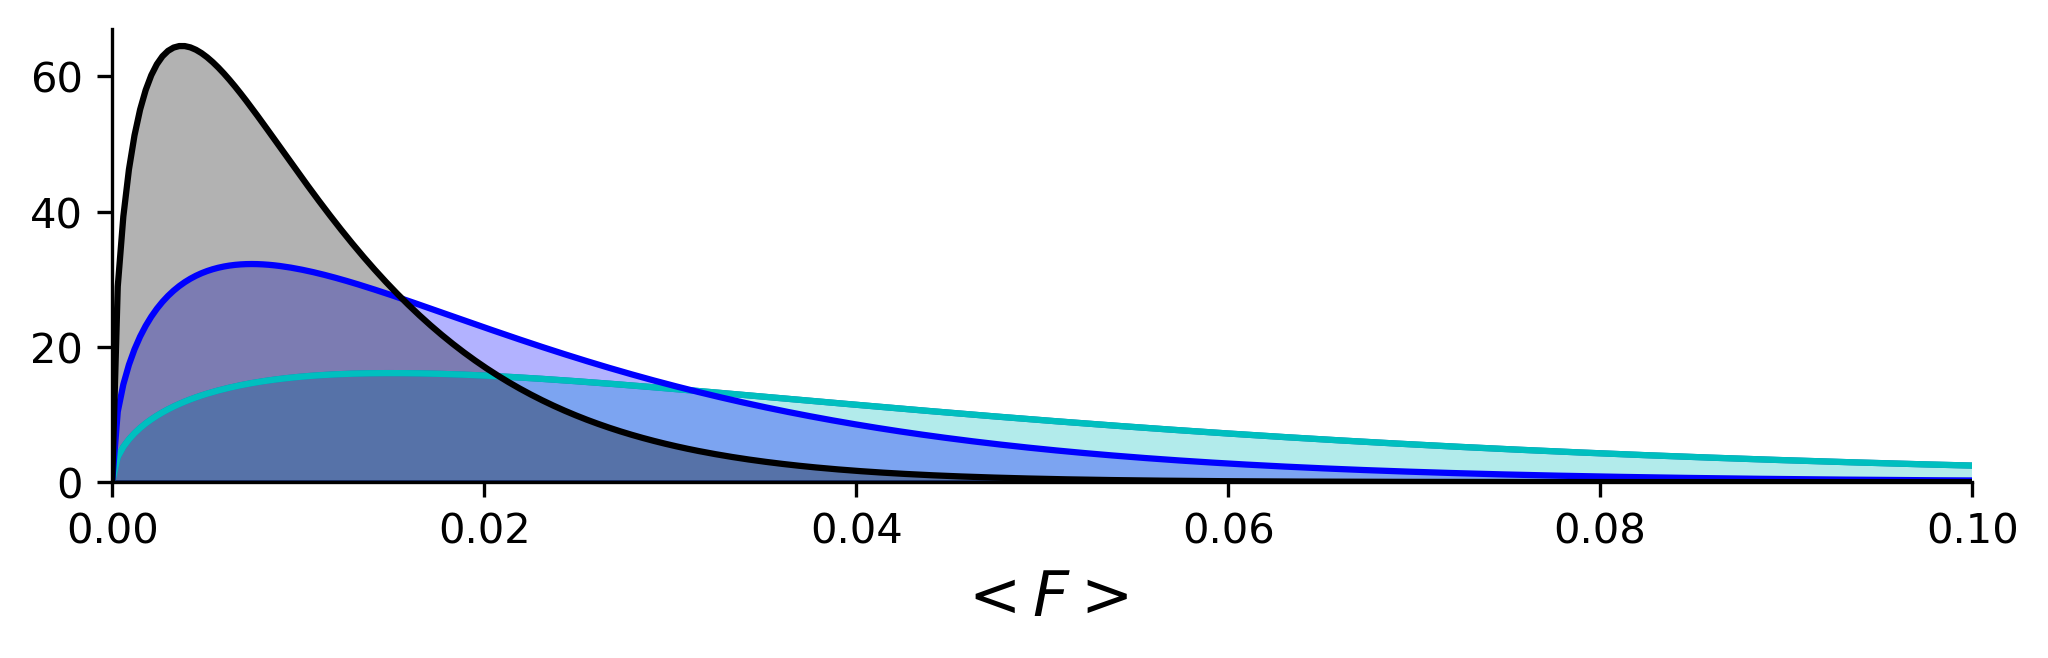

In [81]:
plt.figure(figsize=(8,2),dpi=300)

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  


sigma=0.015
sigma_2=sigma**2
x=np.linspace(0,0.3,1000)
plt.plot(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*200/3))
#plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)))

plt.plot(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*200/3),c='c')
plt.plot(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*100/3),c='b')
plt.plot(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*50/3),c='k')
plt.fill(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*200/(3)), facecolor='c', edgecolor='c', linewidth=1,alpha=0.3)
plt.fill(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*100/(3)), facecolor='b', edgecolor='b', linewidth=1,alpha=0.3)
plt.fill(x,stats.gamma.pdf(x,3/2,0,sigma_2*2*50/(3)), facecolor='k', edgecolor='k', linewidth=1,alpha=0.3)
plt.xlim(0,0.1)
plt.ylim(0,67)

plt.xlabel(r'$<F>$',fontsize=15)




plt.savefig('distributions1.pdf',bbox_inches = 'tight',pad_inches = 0)

#plt.fill(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)), facecolor='lightsalmon', edgecolor='orangered', linewidth=3)

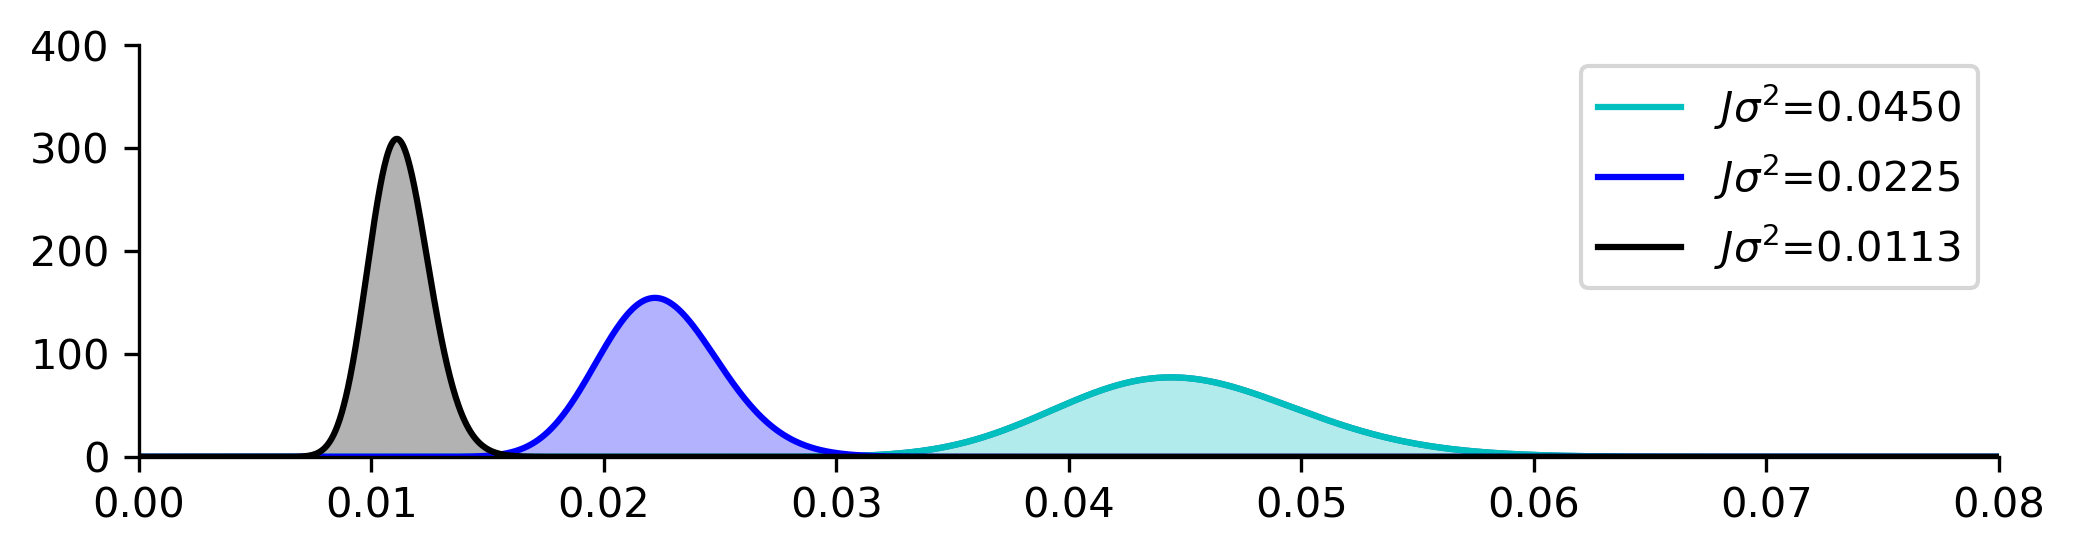

In [83]:
plt.figure(figsize=(8,4),dpi=300)
ax = plt.subplot(211)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  


sigma=0.015
sigma_2=sigma**2
x=np.linspace(0,0.3,10000)
plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)))
#plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)))
plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)),c='c',label=r'$J\sigma^2$=0.0450')
plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*100/(3*50)),c='b',label=r'$J\sigma^2$=0.0225')
plt.plot(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*50/(3*50)),c='k',label=r'$J\sigma^2$=0.0113')
plt.fill(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*200/(3*50)), facecolor='c', edgecolor='c', linewidth=1,alpha=0.3)
plt.fill(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*100/(3*50)), facecolor='b', edgecolor='b', linewidth=1,alpha=0.3)
plt.fill(x,stats.gamma.pdf(x,3*50/2,0,sigma_2*2*50/(3*50)), facecolor='k', edgecolor='k', linewidth=1,alpha=0.3)
plt.xlim(0,0.08)
plt.ylim(0,400)
plt.legend()

plt.savefig('distributions2.pdf',bbox_inches = 'tight',pad_inches = 0)

In [84]:
def P(J,nx,ny,nz):
    np.math.factorial(J)/(np.math.factorial(nx)*np.math.factorial(ny)*np.math.factorial(nz))

In [87]:
np.fact(3)

AttributeError: module 'numpy' has no attribute 'fact'

In [162]:
expo=lambda x: 0.5 - (0.5)*np.exp(-0.0002*x)

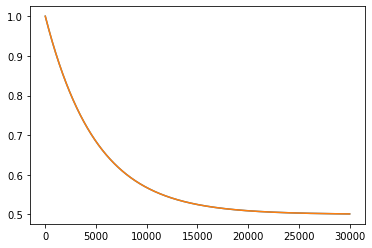

In [177]:
xs=np.linspace(0,30000,100000)
plt.plot(xs,1-expo(xs))
plt.plot(xs,0.5+0.5*(1-0.0002)**xs)

In [107]:
import seaborn as sns
import pandas as pd

In [112]:
rs = np.random.RandomState(5)
mean = [0, 0]
cov = [(1, .5), (.5, 1)]
x = rs.multivariate_normal(mean, cov, 500).T


In [121]:
aaa=np.sum(np.exp(test[0]-np.max(test[0])+np.log(test[1])),axis=0)
bbb=np.sum(np.exp(test[0]-np.max(test[0])+np.log(test[1])),axis=1)

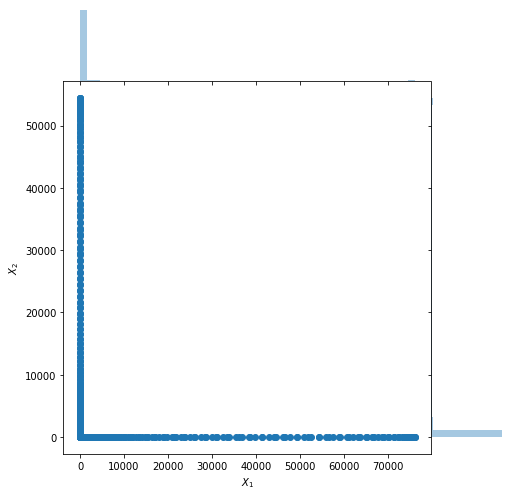

In [127]:
x1 = pd.Series(aaa, name="$X_1$")
x2 = pd.Series(bbb, name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2,height=7, space=0)

In [126]:
x1

0      9.925585e-132
1      8.574468e-116
2      1.231094e-102
3       1.309693e-91
4       2.998457e-82
5       3.224503e-74
6       2.921406e-67
7       3.482384e-61
8       7.718298e-56
9       4.176408e-51
10      6.856229e-47
11      4.069521e-43
12      1.007675e-39
13      1.171114e-36
14      7.045322e-34
15      2.381401e-31
16      4.846491e-29
17      6.297776e-27
18      5.494137e-25
19      3.359576e-23
20      1.494557e-21
21      4.995977e-20
22      1.290769e-18
23      2.641901e-17
24      4.377753e-16
25      5.986496e-15
26      6.871491e-14
27      6.721039e-13
28      5.677656e-12
29      4.192487e-11
           ...      
970     2.052205e-10
971     2.004640e-10
972     1.958221e-10
973     1.912918e-10
974     1.868704e-10
975     1.825552e-10
976     1.783435e-10
977     1.742328e-10
978     1.702205e-10
979     1.663042e-10
980     1.624816e-10
981     1.587502e-10
982     1.551078e-10
983     1.515523e-10
984     1.480815e-10
985     1.446933e-10
986     1.413